# Creación de la base de datos

En este script nos dedicaremos a crear una base de datos de variables de interés de agentes libres de la MBL desde el año 2011 hasta el 2021. Los pasos serán los siguientes:

- **Limpieza individual de las bases de datos respectivas del año 2011.**
- **Creación de la base de datos referente al año 2011.**
- **Repetición del procedimiento, pero ahora para el resto de años.**
- **Unificación de las bases de datos de todos los años separadas en dos grupos.**
- **Creación de visualizaciones de las estadística descriptivas.**

In [134]:
import pandas as pd
import numpy as np
import math
import plotly.express as px
import plotly.graph_objects as go
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib import ticker
from matplotlib import cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly
import os
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
print('Modulos importados')

Modulos importados


In [2]:
print("Para modificar el tamaño de todos los gráficos")
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,9

Para modificar el tamaño de todos los gráficos


In [3]:
print("Para que no nos molesten los mensajes de advertencia.")
import warnings
warnings.filterwarnings('ignore')

Para que no nos molesten los mensajes de advertencia.


In [4]:
# Reduzcamos el número de línea a leer
pd.options.display.max_rows = 10

## Limpieza de datos 2011

Para poder armar la base de datos principal tenemos que armar las bases de datos anuales por temas de eficiencia al usar el método *merge* de *Pandas* ya que nos filtrará las filas de acuerdo a la base de datos de los agentes libres.

Por otro lado, para conocer el significado de los términos involucdrados en las bases de datos se recomienda consultar la siguiente página que es el gloasario oficial de la [MLB](https://www.mlb.com/glossary)

### Método rudimentario

Aquí empieza el algorítmo que se repeirá hasta el año 2021

In [5]:
free_agents_2011 = 'Data/Free_Agents/Free_Agents_2011.csv'
hitting_2011 = 'Data/Statistics/Hitting/HItting_2011.csv'
pitching_2011 = 'Data/Statistics/Pitching/Pitching_2011.csv'
salary_2011 = 'Data/Salary/Salary_2011.csv'

In [6]:
df_fa_2011 = pd.read_csv(free_agents_2011)
df_h_2011 = pd.read_csv(hitting_2011)
df_p_2011 = pd.read_csv(pitching_2011)
df_s_2011 = pd.read_csv(salary_2011)

Para mantener un *back up* de los dataframes originales, crearemos copias de los dataframes anteriores.

In [7]:
df_fa_2011_c = df_fa_2011.copy()
df_h_2011_c = df_h_2011.copy()
df_p_2011_c = df_p_2011.copy()
df_s_2011_c = df_s_2011.copy()

AHora, solo conservaremos las variables de interés para el análisis, se buiscará conservar variables que tomen en cuenta a otras variables o variables únicas de utilidad

### Agentes libres

Veamos primero el dataframe

In [8]:
df_fa_2011_c.head()

,Rank,Player,Year,Pos,Status,Team From,Team From To,YRS,Value,AAV
0,1,Wil Nieves,2011,C,UFA,WSH,MIL,1,"$775,000","$775,000"


Nos quedaremos con el nombre del jugador, los equpos en los que ha estado, años en el equipo y 

In [9]:
df_fa_2011_c = df_fa_2011_c[['Player','Team From', 'Team From To', 'YRS', 'Value', 'AAV']]
df_fa_2011_c_names = ['Jugador','Equipo_anterior_11', 'Equipo_posterior_11', 'Anios_contrato_11', 'Valor_contrato_11', 'Valor_promedio_contrato_11']
df_fa_2011_c.columns = df_fa_2011_c_names
df_fa_2011_c.head()

,Jugador,Equipo_anterior_11,Equipo_posterior_11,Anios_contrato_11,Valor_contrato_11,Valor_promedio_contrato_11
0,Wil Nieves,WSH,MIL,1,"$775,000","$775,000"


En la columna del *Valor_contrato* contiene el caracter especial _$_, por lo que tenemos que removerlo ya que necesitamos que sea la columna del tipo flotante. Por otro lado, también tenemos que eliminar las comas en las columnas para después convertir los tipos de datos de las columnas al adecuado.

In [10]:
fa_aux_1 = df_fa_2011_c['Valor_contrato_11'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
fa_aux_3 = df_fa_2011_c['Valor_promedio_contrato_11'].str.replace("$","")
fa_aux_4 = fa_aux_3.str.replace(",","")
df_fa_2011_c['Valor_contrato_11'] = fa_aux_2
df_fa_2011_c['Valor_promedio_contrato_11'] = fa_aux_4
df_fa_2011_c.head()

,Jugador,Equipo_anterior_11,Equipo_posterior_11,Anios_contrato_11,Valor_contrato_11,Valor_promedio_contrato_11
0,Wil Nieves,WSH,MIL,1,775000,775000


Corroboremos el tipo de datos almacenados en cada columna.

In [11]:
df_fa_2011_c.dtypes

Jugador                       object
Equipo_anterior_11            object
Equipo_posterior_11           object
Anios_contrato_11              int64
Valor_contrato_11             object
Valor_promedio_contrato_11    object
dtype: object

Claramente hay columnas que tienen que ser transformadas a datos de caracter numérico, pero están como cadenas de texto.

In [12]:
df_fa_2011_c['Valor_contrato_11'] = pd.to_numeric(df_fa_2011_c['Valor_contrato_11'])
df_fa_2011_c['Valor_promedio_contrato_11'] = pd.to_numeric(df_fa_2011_c['Valor_promedio_contrato_11'])
df_fa_2011_c.dtypes

Jugador                       object
Equipo_anterior_11            object
Equipo_posterior_11           object
Anios_contrato_11              int64
Valor_contrato_11              int64
Valor_promedio_contrato_11     int64
dtype: object

Ahora todos los datos están en el formato correcto.

### Hitting

Veamos el dataframe

In [13]:
df_h_2011_c.head()

,Rank,Player,Pos,Team,GP,GP%,AB,H,HR,RBI,AVG,OPS,Cash2022
0,1,Adrian Gonzalez,1B,BOS,159,0.982,630,213,27,117,0.338,0.957,$0
1,2,Jacoby Ellsbury,CF,BOS,158,0.975,660,212,32,105,0.321,0.928,$0
2,3,Starlin Castro,2B,CHC,158,0.975,674,207,10,66,0.307,0.773,$0
3,4,Melky Cabrera,LF,KC,155,0.957,658,201,18,87,0.306,0.809,$0
4,5,Miguel Cabrera,1B,DET,161,0.994,572,197,30,105,0.344,1.033,"$32,000,000"


import pandas as pd
import numpy as np
import math
import plotly.express as px
import plotly.graph_objects as go
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib import ticker
from matplotlib import cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly
import os
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score#### Notación

Los términos en la base de datos no se traducirán para evitar malentendidos en la traducción.

- **GP**: Games played.
- **GP%**: Games played %.
- **AB**: At bats.
- **H**: Hitting.
- **HR**: Home runs.
- **RBI**: Runs batted in.
- **AVG**: Batting average.
- **OPS**: Onebase plus slugging%.


#### Games Played

A player is credited with having played a game if he appears in it at any point -- be it as a starter or a replacement. It's important to note that the player doesn't necessarily need an at-bat. He can also enter for defense or as a pinch-runner. Typically, if a player records 162 games played, it means that he appeared in every game that season. But there have been instances in the past where players have exceeded that number -- either because they were traded during the season or because they played in a tiebreaker game at the end of the season.

https://www.mlb.com/glossary/standard-stats/games-played


#### At bats

An official at-bat comes when a batter reaches base via a fielder's choice, hit or an error (not including catcher's interference) or when a batter is put out on a non-sacrifice. (Whereas a plate appearance refers to each completed turn batting, regardless of the result.) At-bats are used as the denominator when determining batting average and slugging percentage. Players who bat higher in the order will typically finish the season with more at-bats than players who hit toward the bottom. Similarly, players who walk infrequently also typically record a higher-than-usual number of at-bats in a season, because walks do not count as at-bats.

https://www.mlb.com/glossary/standard-stats/at-bat


#### RBI

A batter is credited with an RBI in most cases where the result of his plate appearance is a run being scored. There are a few exceptions, however. A player does not receive an RBI when the run scores as a result of an error or ground into double play. The most common examples of RBIs are run-scoring hits. However, players also receive an RBI for a bases-loaded walk or hit by pitch. Players can earn RBIs when they make outs, as well, provided the out results in a run or runs (except, as noted above, in the case of double plays). Along with home runs and batting average, RBIs are a part of baseball's offensive Triple Crown.

https://www.mlb.com/glossary/standard-stats/runs-batted-in


#### AVG

One of the oldest and most universal tools to measure a hitter's success at the plate, batting average is determined by dividing a player's hits by his total at-bats for a number between zero (shown as .000) and one (1.000). In recent years, the league-wide batting average has typically hovered around .250. While batting average is a useful tool for measuring a player's ability at the plate, it isn't all-encompassing. For instance, batting average doesn't take into account the number of times a batter reaches base via walks or hit-by-pitches. And it doesn't take into account hit type (with a double, triple or home run being more valuable than a single).  Batting average can also be applied in evaluating pitchers. In this case, it is called either "opponents' batting average" or "batting average against," and it is determined by dividing the number of hits against a given pitcher by the number of at-bats against him. BAA is very common in evaluating pitchers -- especially when assessing opponent handed-ness splits. A pitcher cannot have an ERA against left-handed hitters because they are interspersed with righties in lineups. So when a pitcher's ability against hitters from each side of the plate is being compared, it is usually done by using either BAA or OPS-against.

https://www.mlb.com/glossary/standard-stats/batting-average


#### OPS

OPS adds on-base percentage and slugging percentage to get one number that unites the two. It's meant to combine how well a hitter can reach base, with how well he can hit for average and for power.


https://www.mlb.com/glossary/standard-stats/on-base-plus-slugging

In [14]:
df_h_2011_c = df_h_2011_c[['Player', 'GP%', 'AVG', 'OPS']]
df_h_2011_c_names = ['Jugador', 'Porcetnaje_juegos_11', 'Porcentaje_bateo_11', 'OPS_11']
df_h_2011_c.columns = df_h_2011_c_names
df_h_2011_c.head()

,Jugador,Porcetnaje_juegos_11,Porcentaje_bateo_11,OPS_11
0,Adrian Gonzalez,0.982,0.338,0.957
1,Jacoby Ellsbury,0.975,0.321,0.928
2,Starlin Castro,0.975,0.307,0.773
3,Melky Cabrera,0.957,0.306,0.809
4,Miguel Cabrera,0.994,0.344,1.033


Corroboremos los tipos de datos.

In [15]:
df_h_2011_c.dtypes

Jugador                  object
Porcetnaje_juegos_11    float64
Porcentaje_bateo_11     float64
OPS_11                  float64
dtype: object

En este caso, todos los datos tienen los datos adecuados.

## Pitching

In [16]:
df_p_2011_c.head()

,Rank,Player,Pos,Team,GP,GS,IP,H,R,ER,BB,SO,W,L,SV,WHIP,ERA,Cash2022
0,1,Justin Verlander,SP,DET,34,34,251.0,174,73,67,57,250,24,5,0,0.92,2.40,"$25,000,000"
1,2,James Shields,SP,TB,33,33,249.3,195,83,78,65,225,16,12,0,1.04,2.82,$0
2,3,Dan Haren,SP,LAA,35,34,238.3,211,91,84,33,192,16,10,0,1.02,3.17,$0
3,4,C.C. Sabathia,SP,NYY,33,33,237.3,230,87,79,61,230,19,8,0,1.23,3.00,$0
4,5,Jered Weaver,SP,LAA,33,33,235.7,182,65,63,56,198,18,8,0,1.01,2.41,$0


#### Notación.

Veamos a qué se refieren algunos términos

- **GP**: Games played.
- **GS**: Games started.
- **IP**: Inning pitched.
- **H**: Hits.
- **R**: Runs.
- **ER**: Earned runs.
- **BB**: Walks.
- **SO**: Strikeouts.
- **W**: Wins.
- **L**: Losses-
- **SV**: Saves.
- **WHIP**: WHIP.
- **ERA**: Earned runs average.


#### Game started

A pitcher is credited with a game started if he is the first pitcher to throw a pitch for his team in a given game. A starter who pitches a full season in a five-man rotation will generally tally at most 34 games started. There is no minimum innings plateau for a pitcher to earn a game started, but a starter must pitch at least five innings to be eligible for a win. Beginning in 2018, teams started experimenting with the idea of using an "opener." Much like a closer, the opener is responsible only for an inning (sometimes two). The opener generally gives way to a reliever in the second or third inning. The prevailing wisdom behind an opener is that it's better for a quality reliever to face the top of the order early in a game than a team's fourth-best or fifth-best starting option. It can also be beneficial to have a right-handed opener face an all-right-handed top of the order or a left-handed opener face multiple imposing lefties. Openers are credited with games started and generally have the opportunity to make more starts than a traditional starting pitcher would over the course of a full season.

https://www.mlb.com/glossary/standard-stats/games-started


#### Inning pitched

Innings pitched measures the number of innings a pitcher remains in a game. Because there are three outs in an inning, each out recorded represents one-third of an inning pitched. Just because a pitcher appears in a game, doesn't mean he will record an inning pitched or even a third of an inning pitched. In order for a pitcher's IP total to increase, he must be pitching while an out is recorded. (This includes pickoffs and caught stealings, while double plays are worth two-thirds of an inning pitched.) Pitchers are not credited for a third of an inning pitched if a batter reaches on an error because an out was never recorded.

https://www.mlb.com/glossary/standard-stats/innings-pitched


#### Runs

In baseball, a run is scored when a player advances around first, second and third base and returns safely to home plate, touching the bases in that order, before three outs are recorded and all obligations to reach base safely on batted balls are met or assured. A player may score by hitting a home run or by any combination of plays that puts him safely "on base" (that is, on first, second, or third) as a runner and subsequently brings him home. The object of the game is for a team to score more runs than its opponent. The Official Baseball Rules hold that if the third out of an inning is a force out of a runner advancing to any base then, even if another baserunner crosses home plate before that force out is made, his run does not count. However, if the third out is not a force out, but a tag out, then if that other baserunner crosses home plate before that tag out is made, his run will count. In baseball statistics, a player who advances around all the bases to score is credited with a run (R), sometimes referred to as a "run scored". While runs scored is considered an important individual batting statistic, it is regarded as less significant than runs batted in (RBIs). Both individual runs scored and runs batted in are heavily context-dependent; however, the sabermetric statistic runs created provides a more sophisticated assessment of a player's contribution toward producing runs for his team. 

https://en.wikipedia.org/wiki/Run_(baseball)


#### Earned runs

An earned run is any run that scores against a pitcher without the benefit of an error or a passed ball. Often, it is the judgment of the official scorer as to whether a specific run would've scored without the defensive mishap. If a pitcher exits a game with runners on base, any earned runs scored by those runners will count against him. Earned runs is the key counting statistic used in ERA, the most widely accepted barometer of a pitcher's success. If there are no errors or passed balls in a given inning or game, all the runs in that inning or game are earned runs

https://en.wikipedia.org/wiki/Earned_run


#### Walks

A base on balls (BB), also known as a walk, occurs in baseball when a batter receives four pitches that the umpire calls balls, and is in turn awarded first base without the possibility of being called out. The base on balls is defined in Section 2.00 of baseball's Official Rules, and further detail is given in 6.08(a). It is considered a faux pas for a professional player to literally walk to first base; the batter-runner and any advancing runners normally jog on such a play. The term "base on balls" distinguishes a walk from the other manners in which a batter can be awarded first base without liability to be put out (e.g., hit by pitch (HBP), catcher's interference).Though a base on balls, catcher's interference, or a batter hit by a pitched ball all result in the batter (and possibly runners on base) being awarded a base, the term "walk" usually refers only to a base on balls, and not the other methods of reaching base without the bat touching the ball. An important difference is that for a hit batter or catcher's interference, the ball is dead and no one may advance unless forced; the ball is live after a walk (see below for details). A batter who draws a base on balls is commonly said to have been "walked" by the pitcher. When the batter is walked, runners advance one base without liability to be put out only if forced to vacate their base to allow the batter to take first base. If a batter draws a walk with the bases loaded, all preceding runners are forced to advance, including the runner on third base who is forced to home plate to score a run; when a run is forced on a walk, the batter is credited with an RBI per rule 9.04.

https://en.wikipedia.org/wiki/Base_on_balls


#### Wins

A pitcher receives a win when he is the pitcher of record when his team takes the lead for good -- with a couple rare exceptions. First, a starting pitcher must pitch at least five innings (in a traditional game of nine innings or longer) to qualify for the win. If he does not, the official scorer awards the win to the most effective relief pitcher. There is also a rarely used clause where an official scorer can deem a relief pitcher's appearance "brief and ineffective." (For example, if a reliever relinquished a one-run lead by allowing three runs, but was still in line for a win after his team scored four runs in the following inning -- that may qualify.) If that's the case, the scorer can award the win to a pitcher who followed that "brief and ineffective" pitcher. Which relief pitcher earns the win specifically is also up to the judgment of the official scorer.


https://www.mlb.com/glossary/standard-stats/win


#### Losses

A pitcher receives a loss when a run that is charged to him proves to be the go-ahead run in the game, giving the opposing team a lead it never gives up. Losses are almost always paired with wins when used to evaluate a pitcher, creating a separate pitching term known as win-loss record. Win-loss record took on a greater importance in the past for a different reason. In the time when pitchers routinely pitched complete games, bullpens were rarely at fault for losses. But today's specialization of relief pitchers has led to starters pitching fewer innings. A starting pitcher does not necessarily receive a loss every time his team loses -- even if he exits the game with his team trailing. In such instances, if his team ties the game or takes the lead before eventually losing, it will be the pitcher who put the go-ahead run on base who takes the loss.

https://www.mlb.com/glossary/standard-stats/loss


#### Saves

A save is awarded to the relief pitcher who finishes a game for the winning team, under certain circumstances. A pitcher cannot receive a save and a win in the same game. A relief pitcher recording a save must preserve his team's lead while doing one of the following:

- Enter the game with a lead of no more than three runs and pitch at least one inning.
- Enter the game with the tying run in the on-deck circle, at the plate or on the bases.
- Pitch at least three innings.

https://www.mlb.com/glossary/standard-stats/save


#### WHIP

WHIP is one of the most commonly used statistics for evaluating a pitcher's performance. The statistic shows how well a pitcher has kept runners off the basepaths, one of his main goals. The formula is simple enough -- it's the sum of a pitcher's walks and hits, divided by his total innings pitched. The pitchers with the lowest WHIPs are generally the best pitchers in the league -- which makes sense, because the best pitchers should be able to prevent baserunners. However, WHIP does not consider the way in which a hitter reached base. (Obviously, home runs are more harmful to pitchers than walks.) Hit batsmen, errors and hitters who reach via fielder's choice do not count against a pitcher's WHIP.

https://www.mlb.com/glossary/standard-stats/walks-and-hits-per-inning-pitched


#### ERA

Earned run average represents the number of earned runs a pitcher allows per nine innings -- with earned runs being any runs that scored without the aid of an error or a passed ball. ERA is the most commonly accepted statistical tool for evaluating pitchers. The formula for finding ERA is: 9 x earned runs / innings pitched. If a pitcher exits a game with runners on base, any earned runs scored by those runners will count against him. ERA should be an ideal evaluation of pitchers. The goal of pitching is to prevent runs from scoring, and ERA tells us basically how well a pitcher does that. How many runs does he allow, on average, that are his fault in a given game? But there are a few flaws with ERA, because so many different factors can affect it. While defensive mistakes are taken into account, great defensive plays are not. So a pitcher with an average defense is at a disadvantage to a pitcher with a great defense. It's also hard to evaluate ERA across the two leagues in Major League Baseball, because the absence of a designated hitter in the National League tends to keep pitchers' ERAs lower. Even the ballpark in which a pitcher pitches can affect a pitcher's ERA because certain stadiums are more conducive to run scoring. Still, ERA is a useful tool for measuring a starting pitcher's success. However, it's not quite as effective in measuring relief pitchers, who often pitch only fractions of an inning -- sometimes leaving their ERA in the hands of other relievers. Even relief pitchers who pitch a full inning tend to exert all their energy on those three outs, instead of spreading it out over the course of a game. This means relievers generally have lower ERAs than starting pitchers.

https://www.mlb.com/glossary/standard-stats/earned-run-average


Vemos que hay variables que toman en consideración a otras como *WHIP* y *ERA*, es por esa razón que las consideraremos en lugar de las varaibales a las cuales resumen. Por otro lado, también hay variables de importancia tales como *Win* o *Saves* que indican si fueron vitales para la victoria del equipo.

In [17]:
df_p_2011_c = df_p_2011_c[['Player', 'W', 'SV', 'WHIP', 'ERA']]
df_p_2011_c_names = ['Jugador', 'Wins_11', 'Saves_11', 'WHIP_11', 'ERA_11']
df_p_2011_c.columns = df_p_2011_c_names
df_p_2011_c.head()

,Jugador,Wins_11,Saves_11,WHIP_11,ERA_11
0,Justin Verlander,24,0,0.92,2.40
1,James Shields,16,0,1.04,2.82
2,Dan Haren,16,0,1.02,3.17
3,C.C. Sabathia,19,0,1.23,3.00
4,Jered Weaver,18,0,1.01,2.41


Corroboremos los tipos de datos almacenados.

In [18]:
df_p_2011_c.dtypes

Jugador      object
Wins_11       int64
Saves_11      int64
WHIP_11     float64
ERA_11      float64
dtype: object

Se aprecia que todo está en correcto.

### Compensación salarial

En este caso, hay muchas menos variables que en las anteriores bases de datos

In [19]:
df_s_2011_c.head()

,Rank,Player,Year,Pos,Team,BaseSalary,Payroll Salary,Adj Salary
0,1,Alex Rodriguez,2011,DH,NYY,"$31,000,000","$32,000,000","$32,000,000"
1,2,Vernon Wells,2011,LF,LAA,"$23,000,000","$26,187,500","$18,000,000"
2,3,C.C. Sabathia,2011,SP,NYY,"$24,285,714","$25,571,428","$25,571,428"
3,4,Mark Teixeira,2011,1B,NYY,"$22,500,000","$23,125,000","$23,125,000"
4,5,Joe Mauer,2011,1B,MIN,"$23,000,000","$23,000,000","$23,000,000"


- **BaseSalary**: A base salary is the minimum amount you can expect to earn in exchange for your time or services. This is the amount earned before benefits, bonuses, or compensation is added.
- **Payroll Salary**: Payroll is the compensation a business must pay to its employees for a set period and on a given date.
- **Adj Salary**: Adjusted Salary means the regular salary, wages and commissions, if any, payable to a Participant by the Company for the Participant's service, excluding any bonuses or other compensation.

Nos quedaremos con las columnas de *Player*, *Team* y *Payroll Salary*.

In [20]:
df_s_2011_c = df_s_2011_c[['Player','Team', 'Payroll Salary']]
df_s_2011_c_names = ['Jugador','Equipo_11', 'Sueldo_11']
df_s_2011_c.columns = df_s_2011_c_names
df_s_2011_c.head()

,Jugador,Equipo_11,Sueldo_11
0,Alex Rodriguez,NYY,"$32,000,000"
1,Vernon Wells,LAA,"$26,187,500"
2,C.C. Sabathia,NYY,"$25,571,428"
3,Mark Teixeira,NYY,"$23,125,000"
4,Joe Mauer,MIN,"$23,000,000"


Análogamente a un caso anterior, tenemos que tranformar la columna del sueldo por los caractéres especiales.

In [21]:
s_aux_1 = df_s_2011_c['Sueldo_11'].str.replace("$","")
s_aux_2 = s_aux_1.str.replace(",","")
df_s_2011_c['Sueldo_11'] = s_aux_2
df_s_2011_c.head()

,Jugador,Equipo_11,Sueldo_11
0,Alex Rodriguez,NYY,32000000
1,Vernon Wells,LAA,26187500
2,C.C. Sabathia,NYY,25571428
3,Mark Teixeira,NYY,23125000
4,Joe Mauer,MIN,23000000


Verifiquemos el tipo de datos almacenados en cada columna.

In [22]:
df_s_2011_c.dtypes

Jugador      object
Equipo_11    object
Sueldo_11    object
dtype: object

Tenemos un caso análogo al primer caso de limpieza de datos:

In [23]:
fa_aux_1 = df_s_2011_c['Sueldo_11'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
df_s_2011_c['Sueldo_11'] = fa_aux_2
df_s_2011_c['Sueldo_11'] = pd.to_numeric(df_s_2011_c['Sueldo_11'])
print("\n" + str(df_s_2011_c.dtypes))


Jugador      object
Equipo_11    object
Sueldo_11     int64
dtype: object


## Unión de las bases de datos 2011

En este caso, solo nos interesan los agentes libres, por lo que solo conservaremos dichos registros mediante el método *merge* de *Pandas* con los parámetros por defecto. Sin embargo, tenemos que considerar que no todos los *pitchers* son *batters* y viceversa, por lo que se crearán dos bases por separado para luego unirlas en su respectivo grupo a lo largo de todos los años.

### Batters free agents dataframe

In [24]:
aux_11_1 = pd.merge(df_fa_2011_c, df_h_2011_c, on='Jugador')
dataframe_h_11 = pd.merge(aux_11_1, df_s_2011_c, on='Jugador')
dataframe_h_11.head()

,Jugador,Equipo_anterior_11,Equipo_posterior_11,Anios_contrato_11,Valor_contrato_11,Valor_promedio_contrato_11,Porcetnaje_juegos_11,Porcentaje_bateo_11,OPS_11,Equipo_11,Sueldo_11
0,Wil Nieves,WSH,MIL,1,775000,775000,0.124,0.14,0.369,MIL,775000


### Pitchers free agents dataframe

In [25]:
aux_11_2 = pd.merge(df_fa_2011_c, df_p_2011_c, on='Jugador')
dataframe_p_11 = pd.merge(aux_11_2, df_s_2011_c, on='Jugador')
dataframe_p_11.head()

,Equipo_anterior_11,Equipo_posterior_11,Anios_contrato_11,Valor_contrato_11,Valor_promedio_contrato_11,Wins_11,Saves_11,WHIP_11,ERA_11,Jugador,Equipo_11,Sueldo_11


## Repetición del procedimiento para los dmeás años

### 2012

In [26]:
free_agents_2012 = 'Data/Free_Agents/Free_Agents_2012.csv'
hitting_2012 = 'Data/Statistics/Hitting/HItting_2012.csv'
pitching_2012 = 'Data/Statistics/Pitching/Pitching_2012.csv'
salary_2012 = 'Data/Salary/Salary_2012.csv'

df_fa_2012 = pd.read_csv(free_agents_2012)
df_h_2012 = pd.read_csv(hitting_2012)
df_p_2012 = pd.read_csv(pitching_2012)
df_s_2012 = pd.read_csv(salary_2012)

df_fa_2012_c = df_fa_2012.copy()
df_h_2012_c = df_h_2012.copy()
df_p_2012_c = df_p_2012.copy()
df_s_2012_c = df_s_2012.copy()

In [27]:
df_fa_2012_c = df_fa_2012_c[['Player','Team From', 'Team From To', 'YRS', 'Value', 'AAV']]
df_fa_2012_c_names = ['Jugador','Equipo_anterior_12', 'Equipo_posterior_12', 'Anios_contrato_12', 'Valor_contrato_12', 'Valor_promedio_contrato_12']
df_fa_2012_c.columns = df_fa_2012_c_names

In [28]:
fa_aux_1 = df_fa_2012_c['Valor_contrato_12'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
fa_aux_3 = df_fa_2012_c['Valor_promedio_contrato_12'].str.replace("$","")
fa_aux_4 = fa_aux_3.str.replace(",","")
df_fa_2012_c['Valor_contrato_12'] = fa_aux_2
df_fa_2012_c['Valor_promedio_contrato_12'] = fa_aux_4

In [29]:
df_fa_2012_c['Valor_contrato_12'] = pd.to_numeric(df_fa_2012_c['Valor_contrato_12'])
df_fa_2012_c['Valor_promedio_contrato_12'] = pd.to_numeric(df_fa_2012_c['Valor_promedio_contrato_12'])

In [30]:
df_h_2012_c = df_h_2012_c[['Player', 'GP%', 'AVG', 'OPS']]
df_h_2012_c_names = ['Jugador', 'Porcetnaje_juegos_12', 'Porcentaje_bateo_12', 'OPS_12']
df_h_2012_c.columns = df_h_2012_c_names

In [31]:
df_p_2012_c = df_p_2012_c[['Player', 'W', 'SV', 'WHIP', 'ERA']]
df_p_2012_c_names = ['Jugador', 'Wins_12', 'Saves_12', 'WHIP_12', 'ERA_12']
df_p_2012_c.columns = df_p_2012_c_names

In [32]:
df_s_2012_c = df_s_2012_c[['Player','Team', 'Payroll Salary']]
df_s_2012_c_names = ['Jugador','Equipo_12', 'Sueldo_12']
df_s_2012_c.columns = df_s_2012_c_names

In [33]:
s_aux_1 = df_s_2012_c['Sueldo_12'].str.replace("$","")
s_aux_2 = s_aux_1.str.replace(",","")
df_s_2012_c['Sueldo_12'] = s_aux_2

In [34]:
fa_aux_1 = df_s_2012_c['Sueldo_12'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
df_s_2012_c['Sueldo_12'] = fa_aux_2
df_s_2012_c['Sueldo_12'] = pd.to_numeric(df_s_2012_c['Sueldo_12'])

In [35]:
aux_12_1 = pd.merge(df_fa_2012_c, df_h_2012_c, on='Jugador')
dataframe_h_12 = pd.merge(aux_12_1, df_s_2012_c, on='Jugador')
dataframe_h_12.head()

,Jugador,Equipo_anterior_12,Equipo_posterior_12,Anios_contrato_12,Valor_contrato_12,Valor_promedio_contrato_12,Porcetnaje_juegos_12,Porcentaje_bateo_12,OPS_12,Equipo_12,Sueldo_12
0,Albert Pujols,STL,LAA,10,240000000,24000000,0.951,0.285,0.859,LAA,12000000
1,Prince Fielder,MIL,DET,9,214000000,23777778,1.000,0.313,0.940,DET,23150000
2,Jose Reyes,NYM,MIA,6,106000000,17666667,0.988,0.287,0.780,MIA,10000000
3,C.J. Wilson,TEX,LAA,5,77500000,15500000,0.210,0.000,0.167,LAA,10550000
4,Mark Buehrle,CHW,MIA,4,58000000,14500000,0.191,0.045,0.104,MIA,7000000


In [36]:
aux_12_2 = pd.merge(df_fa_2012_c, df_p_2012_c, on='Jugador')
dataframe_p_12 = pd.merge(aux_12_2, df_s_2012_c, on='Jugador')
dataframe_p_12.head()

,Jugador,Equipo_anterior_12,Equipo_posterior_12,Anios_contrato_12,Valor_contrato_12,Valor_promedio_contrato_12,Wins_12,Saves_12,WHIP_12,ERA_12,Equipo_12,Sueldo_12
0,C.J. Wilson,TEX,LAA,5,77500000,15500000,13,0,1.34,3.83,LAA,10550000
1,Mark Buehrle,CHW,MIA,4,58000000,14500000,13,0,1.17,3.74,MIA,7000000
2,Jonathan Papelbon,BOS,PHI,4,50000000,12500000,5,38,1.06,2.44,PHI,11000058
3,Heath Bell,SD,MIA,3,27000000,9000000,4,19,1.55,5.09,MIA,7000000
4,Joe Nathan,MIN,TEX,2,14000000,7000000,3,37,1.06,2.80,TEX,8050000


### 2013

In [37]:
free_agents_2013 = 'Data/Free_Agents/Free_Agents_2013.csv'
hitting_2013 = 'Data/Statistics/Hitting/HItting_2013.csv'
pitching_2013 = 'Data/Statistics/Pitching/Pitching_2013.csv'
salary_2013 = 'Data/Salary/Salary_2013.csv'

df_fa_2013 = pd.read_csv(free_agents_2013)
df_h_2013 = pd.read_csv(hitting_2013)
df_p_2013 = pd.read_csv(pitching_2013)
df_s_2013 = pd.read_csv(salary_2013)

df_fa_2013_c = df_fa_2013.copy()
df_h_2013_c = df_h_2013.copy()
df_p_2013_c = df_p_2013.copy()
df_s_2013_c = df_s_2013.copy()

df_fa_2013_c = df_fa_2013_c[['Player','Team From', 'Team From To', 'YRS', 'Value', 'AAV']]
df_fa_2013_c_names = ['Jugador','Equipo_anterior_13', 'Equipo_posterior_13', 'Anios_contrato_13', 'Valor_contrato_13', 'Valor_promedio_contrato_13']
df_fa_2013_c.columns = df_fa_2013_c_names

fa_aux_1 = df_fa_2013_c['Valor_contrato_13'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
fa_aux_3 = df_fa_2013_c['Valor_promedio_contrato_13'].str.replace("$","")
fa_aux_4 = fa_aux_3.str.replace(",","")
df_fa_2013_c['Valor_contrato_13'] = fa_aux_2
df_fa_2013_c['Valor_promedio_contrato_13'] = fa_aux_4

df_fa_2013_c['Valor_contrato_13'] = pd.to_numeric(df_fa_2013_c['Valor_contrato_13'])
df_fa_2013_c['Valor_promedio_contrato_13'] = pd.to_numeric(df_fa_2013_c['Valor_promedio_contrato_13'])

df_h_2013_c = df_h_2013_c[['Player', 'GP%', 'AVG', 'OPS']]
df_h_2013_c_names = ['Jugador', 'Porcetnaje_juegos_13', 'Porcentaje_bateo_13', 'OPS_13']
df_h_2013_c.columns = df_h_2013_c_names

df_p_2013_c = df_p_2013_c[['Player', 'W', 'SV', 'WHIP', 'ERA']]
df_p_2013_c_names = ['Jugador', 'Wins_13', 'Saves_13', 'WHIP_13', 'ERA_13']
df_p_2013_c.columns = df_p_2013_c_names

df_s_2013_c = df_s_2013_c[['Player','Team', 'Payroll Salary']]
df_s_2013_c_names = ['Jugador','Equipo_13', 'Sueldo_13']
df_s_2013_c.columns = df_s_2013_c_names

s_aux_1 = df_s_2013_c['Sueldo_13'].str.replace("$","")
s_aux_2 = s_aux_1.str.replace(",","")
df_s_2013_c['Sueldo_13'] = s_aux_2

fa_aux_1 = df_s_2013_c['Sueldo_13'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
df_s_2013_c['Sueldo_13'] = fa_aux_2
df_s_2013_c['Sueldo_13'] = pd.to_numeric(df_s_2013_c['Sueldo_13'])

aux_13_1 = pd.merge(df_fa_2013_c, df_h_2013_c, on='Jugador')
dataframe_h_13 = pd.merge(aux_13_1, df_s_2013_c, on='Jugador')
dataframe_h_13.head()

,Jugador,Equipo_anterior_13,Equipo_posterior_13,Anios_contrato_13,Valor_contrato_13,Valor_promedio_contrato_13,Porcetnaje_juegos_13,Porcentaje_bateo_13,OPS_13,Equipo_13,Sueldo_13
0,Zack Greinke,LAA,LAD,6,147000000,24500000,0.179,0.328,0.788,LAD,19000000
1,Josh Hamilton,TEX,LAA,5,125000000,25000000,0.932,0.250,0.739,LAA,17400000
2,Anibal Sanchez,DET,DET,5,80000000,16000000,0.179,0.000,0.200,DET,8800000
3,Melvin Upton,TB,ATL,5,72500000,14500000,0.778,0.184,0.557,ATL,13050000
4,Edwin Jackson,WSH,CHC,4,52000000,13000000,0.191,0.077,0.265,CHC,13000000


In [38]:
aux_13_2 = pd.merge(df_fa_2013_c, df_p_2013_c, on='Jugador')
dataframe_p_13 = pd.merge(aux_13_2, df_s_2013_c, on='Jugador')
dataframe_p_13.head()

,Jugador,Equipo_anterior_13,Equipo_posterior_13,Anios_contrato_13,Valor_contrato_13,Valor_promedio_contrato_13,Wins_13,Saves_13,WHIP_13,ERA_13,Equipo_13,Sueldo_13
0,Zack Greinke,LAA,LAD,6,147000000,24500000,15,0,1.11,2.63,LAD,19000000
1,Anibal Sanchez,DET,DET,5,80000000,16000000,14,0,1.15,2.57,DET,8800000
2,Edwin Jackson,WSH,CHC,4,52000000,13000000,8,0,1.46,4.98,CHC,13000000
3,Kyle Lohse,STL,MIL,3,33000000,11000000,11,0,1.17,3.35,MIL,4350000
4,Rafael Soriano,NYY,WSH,2,28000000,14000000,3,43,1.23,3.11,WSH,11000000


### 2014

In [39]:
free_agents_2014 = 'Data/Free_Agents/Free_Agents_2014.csv'
hitting_2014 = 'Data/Statistics/Hitting/HItting_2014.csv'
pitching_2014 = 'Data/Statistics/Pitching/Pitching_2014.csv'
salary_2014 = 'Data/Salary/Salary_2014.csv'

df_fa_2014 = pd.read_csv(free_agents_2014)
df_h_2014 = pd.read_csv(hitting_2014)
df_p_2014 = pd.read_csv(pitching_2014)
df_s_2014 = pd.read_csv(salary_2014)

df_fa_2014_c = df_fa_2014.copy()
df_h_2014_c = df_h_2014.copy()
df_p_2014_c = df_p_2014.copy()
df_s_2014_c = df_s_2014.copy()

df_fa_2014_c = df_fa_2014_c[['Player','Team From', 'Team From To', 'YRS', 'Value', 'AAV']]
df_fa_2014_c_names = ['Jugador','Equipo_anterior_14', 'Equipo_posterior_14', 'Anios_contrato_14', 'Valor_contrato_14', 'Valor_promedio_contrato_14']
df_fa_2014_c.columns = df_fa_2014_c_names

fa_aux_1 = df_fa_2014_c['Valor_contrato_14'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
fa_aux_3 = df_fa_2014_c['Valor_promedio_contrato_14'].str.replace("$","")
fa_aux_4 = fa_aux_3.str.replace(",","")
df_fa_2014_c['Valor_contrato_14'] = fa_aux_2
df_fa_2014_c['Valor_promedio_contrato_14'] = fa_aux_4

df_fa_2014_c['Valor_contrato_14'] = pd.to_numeric(df_fa_2014_c['Valor_contrato_14'])
df_fa_2014_c['Valor_promedio_contrato_14'] = pd.to_numeric(df_fa_2014_c['Valor_promedio_contrato_14'])

df_h_2014_c = df_h_2014_c[['Player', 'GP%', 'AVG', 'OPS']]
df_h_2014_c_names = ['Jugador', 'Porcetnaje_juegos_14', 'Porcentaje_bateo_14', 'OPS_14']
df_h_2014_c.columns = df_h_2014_c_names

df_p_2014_c = df_p_2014_c[['Player', 'W', 'SV', 'WHIP', 'ERA']]
df_p_2014_c_names = ['Jugador', 'Wins_14', 'Saves_14', 'WHIP_14', 'ERA_14']
df_p_2014_c.columns = df_p_2014_c_names

df_s_2014_c = df_s_2014_c[['Player','Team', 'Payroll Salary']]
df_s_2014_c_names = ['Jugador','Equipo_14', 'Sueldo_14']
df_s_2014_c.columns = df_s_2014_c_names

s_aux_1 = df_s_2014_c['Sueldo_14'].str.replace("$","")
s_aux_2 = s_aux_1.str.replace(",","")
df_s_2014_c['Sueldo_14'] = s_aux_2

fa_aux_1 = df_s_2014_c['Sueldo_14'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
df_s_2014_c['Sueldo_14'] = fa_aux_2
df_s_2014_c['Sueldo_14'] = pd.to_numeric(df_s_2014_c['Sueldo_14'])

aux_14_1 = pd.merge(df_fa_2014_c, df_h_2014_c, on='Jugador')
dataframe_h_14 = pd.merge(aux_14_1, df_s_2014_c, on='Jugador')
dataframe_h_14.head()

,Jugador,Equipo_anterior_14,Equipo_posterior_14,Anios_contrato_14,Valor_contrato_14,Valor_promedio_contrato_14,Porcetnaje_juegos_14,Porcentaje_bateo_14,OPS_14,Equipo_14,Sueldo_14
0,Robinson Cano,NYY,SEA,10,240000000,24000000,0.969,0.314,0.836,SEA,24050000
1,Jacoby Ellsbury,BOS,NYY,7,153000000,21857143,0.920,0.271,0.747,NYY,21142857
2,Shin-Soo Choo,CIN,TEX,7,130000000,18571429,0.759,0.242,0.714,TEX,14000000
3,Brian McCann,ATL,NYY,5,85000000,17000000,0.864,0.232,0.692,NYY,17000000
4,Curtis Granderson,NYY,NYM,4,60000000,15000000,0.957,0.227,0.714,NYM,13000000


In [40]:
aux_14_2 = pd.merge(df_fa_2014_c, df_p_2014_c, on='Jugador')
dataframe_p_14 = pd.merge(aux_14_2, df_s_2014_c, on='Jugador')
dataframe_p_14.head()

,Jugador,Equipo_anterior_14,Equipo_posterior_14,Anios_contrato_14,Valor_contrato_14,Valor_promedio_contrato_14,Wins_14,Saves_14,WHIP_14,ERA_14,Equipo_14,Sueldo_14
0,Matt Garza,TEX,MIL,4,50000000,12500000,8,0,1.18,3.64,MIL,12500000
1,Ricky Nolasco,LAD,MIN,4,49000000,12250000,6,0,1.52,5.38,MIN,12000000
2,Jason Vargas,LAA,KC,4,32000000,8000000,11,0,1.27,3.71,KC,7000000
3,Scott Feldman,BAL,HOU,3,30000000,10000000,8,0,1.30,3.74,HOU,12000000
4,Tim Hudson,ATL,ATL,3,28000000,9333333,9,0,1.23,3.57,SF,11025000


### 2015

In [41]:
free_agents_2015 = 'Data/Free_Agents/Free_Agents_2015.csv'
hitting_2015 = 'Data/Statistics/Hitting/HItting_2015.csv'
pitching_2015 = 'Data/Statistics/Pitching/Pitching_2015.csv'
salary_2015 = 'Data/Salary/Salary_2015.csv'

df_fa_2015 = pd.read_csv(free_agents_2015)
df_h_2015 = pd.read_csv(hitting_2015)
df_p_2015 = pd.read_csv(pitching_2015)
df_s_2015 = pd.read_csv(salary_2015)

df_fa_2015_c = df_fa_2015.copy()
df_h_2015_c = df_h_2015.copy()
df_p_2015_c = df_p_2015.copy()
df_s_2015_c = df_s_2015.copy()

df_fa_2015_c = df_fa_2015_c[['Player','Team From', 'Team From To', 'YRS', 'Value', 'AAV']]
df_fa_2015_c_names = ['Jugador','Equipo_anterior_15', 'Equipo_posterior_15', 'Anios_contrato_15', 'Valor_contrato_15', 'Valor_promedio_contrato_15']
df_fa_2015_c.columns = df_fa_2015_c_names

fa_aux_1 = df_fa_2015_c['Valor_contrato_15'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
fa_aux_3 = df_fa_2015_c['Valor_promedio_contrato_15'].str.replace("$","")
fa_aux_4 = fa_aux_3.str.replace(",","")
df_fa_2015_c['Valor_contrato_15'] = fa_aux_2
df_fa_2015_c['Valor_promedio_contrato_15'] = fa_aux_4

df_fa_2015_c['Valor_contrato_15'] = pd.to_numeric(df_fa_2015_c['Valor_contrato_15'])
df_fa_2015_c['Valor_promedio_contrato_15'] = pd.to_numeric(df_fa_2015_c['Valor_promedio_contrato_15'])

df_h_2015_c = df_h_2015_c[['Player', 'GP%', 'AVG', 'OPS']]
df_h_2015_c_names = ['Jugador', 'Porcetnaje_juegos_15', 'Porcentaje_bateo_15', 'OPS_15']
df_h_2015_c.columns = df_h_2015_c_names

df_p_2015_c = df_p_2015_c[['Player', 'W', 'SV', 'WHIP', 'ERA']]
df_p_2015_c_names = ['Jugador', 'Wins_15', 'Saves_15', 'WHIP_15', 'ERA_15']
df_p_2015_c.columns = df_p_2015_c_names

df_s_2015_c = df_s_2015_c[['Player','Team', 'Payroll Salary']]
df_s_2015_c_names = ['Jugador','Equipo_15', 'Sueldo_15']
df_s_2015_c.columns = df_s_2015_c_names

s_aux_1 = df_s_2015_c['Sueldo_15'].str.replace("$","")
s_aux_2 = s_aux_1.str.replace(",","")
df_s_2015_c['Sueldo_15'] = s_aux_2

fa_aux_1 = df_s_2015_c['Sueldo_15'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
df_s_2015_c['Sueldo_15'] = fa_aux_2
df_s_2015_c['Sueldo_15'] = pd.to_numeric(df_s_2015_c['Sueldo_15'])

aux_15_1 = pd.merge(df_fa_2015_c, df_h_2015_c, on='Jugador')
dataframe_h_15 = pd.merge(aux_15_1, df_s_2015_c, on='Jugador')
dataframe_h_15.head()

,Jugador,Equipo_anterior_15,Equipo_posterior_15,Anios_contrato_15,Valor_contrato_15,Valor_promedio_contrato_15,Porcetnaje_juegos_15,Porcentaje_bateo_15,OPS_15,Equipo_15,Sueldo_15
0,Max Scherzer,DET,WSH,7,210000000,30000000,0.210,0.217,0.457,WSH,17317857
1,Jon Lester,OAK,CHC,6,155000000,25833333,0.198,0.065,0.172,CHC,20000000
2,Pablo Sandoval,SF,BOS,5,95000000,19000000,0.778,0.247,0.664,BOS,17600000
3,Hanley Ramirez,LAD,BOS,4,88000000,22000000,0.648,0.249,0.717,BOS,19750000
4,Russell Martin,PIT,TOR,5,82000000,16400000,0.796,0.240,0.787,TOR,7000000


In [42]:
aux_15_2 = pd.merge(df_fa_2015_c, df_p_2015_c, on='Jugador')
dataframe_p_15 = pd.merge(aux_15_2, df_s_2015_c, on='Jugador')
dataframe_p_15.head()

,Jugador,Equipo_anterior_15,Equipo_posterior_15,Anios_contrato_15,Valor_contrato_15,Valor_promedio_contrato_15,Wins_15,Saves_15,WHIP_15,ERA_15,Equipo_15,Sueldo_15
0,Max Scherzer,DET,WSH,7,210000000,30000000,14,0,0.92,2.79,WSH,17317857
1,Jon Lester,OAK,CHC,6,155000000,25833333,11,0,1.12,3.34,CHC,20000000
2,James Shields,KC,SD,4,75000000,18750000,13,0,1.33,3.91,SD,10000000
3,Ervin Santana,ATL,MIN,4,55000000,13750000,7,0,1.30,4.00,MIN,7598360
4,Brandon McCarthy,NYY,LAD,4,48000000,12000000,3,0,1.22,5.87,LAD,12500000


### 2016

In [43]:
free_agents_2016 = 'Data/Free_Agents/Free_Agents_2016.csv'
hitting_2016 = 'Data/Statistics/Hitting/HItting_2016.csv'
pitching_2016 = 'Data/Statistics/Pitching/Pitching_2016.csv'
salary_2016 = 'Data/Salary/Salary_2016.csv'

df_fa_2016 = pd.read_csv(free_agents_2016)
df_h_2016 = pd.read_csv(hitting_2016)
df_p_2016 = pd.read_csv(pitching_2016)
df_s_2016 = pd.read_csv(salary_2016)

df_fa_2016_c = df_fa_2016.copy()
df_h_2016_c = df_h_2016.copy()
df_p_2016_c = df_p_2016.copy()
df_s_2016_c = df_s_2016.copy()

df_fa_2016_c = df_fa_2016_c[['Player','Team From', 'Team From To', 'YRS', 'Value', 'AAV']]
df_fa_2016_c_names = ['Jugador','Equipo_anterior_16', 'Equipo_posterior_16', 'Anios_contrato_16', 'Valor_contrato_16', 'Valor_promedio_contrato_16']
df_fa_2016_c.columns = df_fa_2016_c_names

fa_aux_1 = df_fa_2016_c['Valor_contrato_16'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
fa_aux_3 = df_fa_2016_c['Valor_promedio_contrato_16'].str.replace("$","")
fa_aux_4 = fa_aux_3.str.replace(",","")
df_fa_2016_c['Valor_contrato_16'] = fa_aux_2
df_fa_2016_c['Valor_promedio_contrato_16'] = fa_aux_4

df_fa_2016_c['Valor_contrato_16'] = pd.to_numeric(df_fa_2016_c['Valor_contrato_16'])
df_fa_2016_c['Valor_promedio_contrato_16'] = pd.to_numeric(df_fa_2016_c['Valor_promedio_contrato_16'])

df_h_2016_c = df_h_2016_c[['Player', 'Team', 'GP%', 'AVG', 'OPS']]
df_h_2016_c_names = ['Jugador','Equipo_16', 'Porcetnaje_juegos_16', 'Porcentaje_bateo_16', 'OPS_16']
df_h_2016_c.columns = df_h_2016_c_names

df_p_2016_c = df_p_2016_c[['Player', 'W', 'SV', 'WHIP', 'ERA']]
df_p_2016_c_names = ['Jugador', 'Wins_16', 'Saves_16', 'WHIP_16', 'ERA_16']
df_p_2016_c.columns = df_p_2016_c_names

df_s_2016_c = df_s_2016_c[['Player','Team', 'Payroll Salary']]
df_s_2016_c_names = ['Jugador','Equipo_16', 'Sueldo_16']
df_s_2016_c.columns = df_s_2016_c_names

s_aux_1 = df_s_2016_c['Sueldo_16'].str.replace("$","")
s_aux_2 = s_aux_1.str.replace(",","")
df_s_2016_c['Sueldo_16'] = s_aux_2

fa_aux_1 = df_s_2016_c['Sueldo_16'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
df_s_2016_c['Sueldo_16'] = fa_aux_2
df_s_2016_c['Sueldo_16'] = pd.to_numeric(df_s_2016_c['Sueldo_16'])

aux_16_1 = pd.merge(df_fa_2016_c, df_h_2016_c, on='Jugador')
dataframe_h_16 = pd.merge(aux_16_1, df_s_2016_c, on='Jugador')
dataframe_h_16.head()

,Jugador,Equipo_anterior_16,Equipo_posterior_16,Anios_contrato_16,Valor_contrato_16,Valor_promedio_contrato_16,Equipo_16_x,Porcetnaje_juegos_16,Porcentaje_bateo_16,OPS_16,Equipo_16_y,Sueldo_16
0,David Price,TOR,BOS,7,217000000,31000000,BOS,0.216,0.000,0.091,BOS,30000000
1,Zack Greinke,LAD,ARI,6,206500000,34416667,ARI,0.167,0.212,0.476,ARI,34000000
2,Jason Heyward,STL,CHC,8,184000000,23000000,CHC,0.877,0.230,0.631,CHC,21666666
3,Chris Davis,BAL,BAL,7,161000000,23000000,BAL,0.969,0.221,0.792,BAL,21065362
4,Justin Upton,SD,DET,6,132750000,22125000,DET,0.950,0.246,0.775,DET,22125000


In [44]:
aux_16_2 = pd.merge(df_fa_2016_c, df_p_2016_c, on='Jugador')
dataframe_p_16 = pd.merge(aux_16_2, df_s_2016_c, on='Jugador')
dataframe_p_16.head()

,Jugador,Equipo_anterior_16,Equipo_posterior_16,Anios_contrato_16,Valor_contrato_16,Valor_promedio_contrato_16,Wins_16,Saves_16,WHIP_16,ERA_16,Equipo_16,Sueldo_16
0,David Price,TOR,BOS,7,217000000,31000000,17,0,1.20,3.99,BOS,30000000
1,Zack Greinke,LAD,ARI,6,206500000,34416667,13,0,1.27,4.37,ARI,34000000
2,Johnny Cueto,KC,SF,6,130000000,21666667,18,0,1.09,2.79,SF,17500000
3,Jordan Zimmermann,WSH,DET,5,110000000,22000000,9,0,1.37,4.87,DET,18000000
4,Jeff Samardzija,CHW,SF,5,90000000,18000000,12,0,1.20,3.81,SF,10800000


### 2017

In [45]:
free_agents_2017 = 'Data/Free_Agents/Free_Agents_2017.csv'
hitting_2017 = 'Data/Statistics/Hitting/HItting_2017.csv'
pitching_2017 = 'Data/Statistics/Pitching/Pitching_2017.csv'
salary_2017 = 'Data/Salary/Salary_2017.csv'

df_fa_2017 = pd.read_csv(free_agents_2017)
df_h_2017 = pd.read_csv(hitting_2017)
df_p_2017 = pd.read_csv(pitching_2017)
df_s_2017 = pd.read_csv(salary_2017)

df_fa_2017_c = df_fa_2017.copy()
df_h_2017_c = df_h_2017.copy()
df_p_2017_c = df_p_2017.copy()
df_s_2017_c = df_s_2017.copy()

df_fa_2017_c = df_fa_2017_c[['Player','Team From', 'Team From To', 'YRS', 'Value', 'AAV']]
df_fa_2017_c_names = ['Jugador','Equipo_anterior_17', 'Equipo_posterior_17', 'Anios_contrato_17', 'Valor_contrato_17', 'Valor_promedio_contrato_17']
df_fa_2017_c.columns = df_fa_2017_c_names

fa_aux_1 = df_fa_2017_c['Valor_contrato_17'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
fa_aux_3 = df_fa_2017_c['Valor_promedio_contrato_17'].str.replace("$","")
fa_aux_4 = fa_aux_3.str.replace(",","")
df_fa_2017_c['Valor_contrato_17'] = fa_aux_2
df_fa_2017_c['Valor_promedio_contrato_17'] = fa_aux_4

df_fa_2017_c['Valor_contrato_17'] = pd.to_numeric(df_fa_2017_c['Valor_contrato_17'])
df_fa_2017_c['Valor_promedio_contrato_17'] = pd.to_numeric(df_fa_2017_c['Valor_promedio_contrato_17'])

df_h_2017_c = df_h_2017_c[['Player', 'Team', 'GP%', 'AVG', 'OPS']]
df_h_2017_c_names = ['Jugador','Equipo_17', 'Porcetnaje_juegos_17', 'Porcentaje_bateo_17', 'OPS_17']
df_h_2017_c.columns = df_h_2017_c_names

df_p_2017_c = df_p_2017_c[['Player', 'W', 'SV', 'WHIP', 'ERA']]
df_p_2017_c_names = ['Jugador', 'Wins_17', 'Saves_17', 'WHIP_17', 'ERA_17']
df_p_2017_c.columns = df_p_2017_c_names

df_s_2017_c = df_s_2017_c[['Player','Team', 'Payroll Salary']]
df_s_2017_c_names = ['Jugador','Equipo_17', 'Sueldo_17']
df_s_2017_c.columns = df_s_2017_c_names

s_aux_1 = df_s_2017_c['Sueldo_17'].str.replace("$","")
s_aux_2 = s_aux_1.str.replace(",","")
df_s_2017_c['Sueldo_17'] = s_aux_2

fa_aux_1 = df_s_2017_c['Sueldo_17'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
df_s_2017_c['Sueldo_17'] = fa_aux_2
df_s_2017_c['Sueldo_17'] = pd.to_numeric(df_s_2017_c['Sueldo_17'])

aux_17_1 = pd.merge(df_fa_2017_c, df_h_2017_c, on='Jugador')
dataframe_h_17 = pd.merge(aux_17_1, df_s_2017_c, on='Jugador')
dataframe_h_17.head()

,Jugador,Equipo_anterior_17,Equipo_posterior_17,Anios_contrato_17,Valor_contrato_17,Valor_promedio_contrato_17,Equipo_17_x,Porcetnaje_juegos_17,Porcentaje_bateo_17,OPS_17,Equipo_17_y,Sueldo_17
0,Yoenis Cespedes,NYM,NYM,4,110000000,27500000,NYM,0.500,0.292,0.892,NYM,22500000
1,Dexter Fowler,CHC,STL,5,82500000,16500000,STL,0.728,0.264,0.851,STL,16500000
2,Kenley Jansen,LAD,LAD,5,80000000,16000000,LAD,0.401,0.500,1.250,LAD,11333333
3,Ian Desmond,TEX,COL,5,70000000,14000000,COL,0.586,0.274,0.701,COL,8000000
4,Justin Turner,LAD,LAD,4,64000000,16000000,LAD,0.803,0.322,0.945,LAD,13000000


In [46]:
aux_17_2 = pd.merge(df_fa_2017_c, df_p_2017_c, on='Jugador')
dataframe_p_17 = pd.merge(aux_17_2, df_s_2017_c, on='Jugador')
dataframe_p_17.head()

,Jugador,Equipo_anterior_17,Equipo_posterior_17,Anios_contrato_17,Valor_contrato_17,Valor_promedio_contrato_17,Wins_17,Saves_17,WHIP_17,ERA_17,Equipo_17,Sueldo_17
0,Aroldis Chapman,CHC,NYY,5,86000000,17200000,4,22,1.13,3.22,NYY,17200000
1,Kenley Jansen,LAD,LAD,5,80000000,16000000,5,41,0.75,1.32,LAD,11333333
2,Mark Melancon,WSH,SF,4,62000000,15500000,1,11,1.43,4.50,SF,14000000
3,Rich Hill,LAD,LAD,3,48000000,16000000,12,0,1.09,3.32,LAD,12666666
4,Brett Cecil,TOR,STL,4,30500000,7625000,2,1,1.23,3.88,STL,7750000


### 2018

In [47]:
free_agents_2018 = 'Data/Free_Agents/Free_Agents_2018.csv'
hitting_2018 = 'Data/Statistics/Hitting/HItting_2018.csv'
pitching_2018 = 'Data/Statistics/Pitching/Pitching_2018.csv'
salary_2018 = 'Data/Salary/Salary_2018.csv'

df_fa_2018 = pd.read_csv(free_agents_2018)
df_h_2018 = pd.read_csv(hitting_2018)
df_p_2018 = pd.read_csv(pitching_2018)
df_s_2018 = pd.read_csv(salary_2018)

df_fa_2018_c = df_fa_2018.copy()
df_h_2018_c = df_h_2018.copy()
df_p_2018_c = df_p_2018.copy()
df_s_2018_c = df_s_2018.copy()

df_fa_2018_c = df_fa_2018_c[['Player','Team From', 'Team From To', 'YRS', 'Value', 'AAV']]
df_fa_2018_c_names = ['Jugador','Equipo_anterior_18', 'Equipo_posterior_18', 'Anios_contrato_18', 'Valor_contrato_18', 'Valor_promedio_contrato_18']
df_fa_2018_c.columns = df_fa_2018_c_names

fa_aux_1 = df_fa_2018_c['Valor_contrato_18'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
fa_aux_3 = df_fa_2018_c['Valor_promedio_contrato_18'].str.replace("$","")
fa_aux_4 = fa_aux_3.str.replace(",","")
df_fa_2018_c['Valor_contrato_18'] = fa_aux_2
df_fa_2018_c['Valor_promedio_contrato_18'] = fa_aux_4

df_fa_2018_c['Valor_contrato_18'] = pd.to_numeric(df_fa_2018_c['Valor_contrato_18'])
df_fa_2018_c['Valor_promedio_contrato_18'] = pd.to_numeric(df_fa_2018_c['Valor_promedio_contrato_18'])

df_h_2018_c = df_h_2018_c[['Player', 'GP%', 'AVG', 'OPS']]
df_h_2018_c_names = ['Jugador', 'Porcetnaje_juegos_18', 'Porcentaje_bateo_18', 'OPS_18']
df_h_2018_c.columns = df_h_2018_c_names

df_p_2018_c = df_p_2018_c[['Player', 'W', 'SV', 'WHIP', 'ERA']]
df_p_2018_c_names = ['Jugador', 'Wins_18', 'Saves_18', 'WHIP_18', 'ERA_18']
df_p_2018_c.columns = df_p_2018_c_names

df_s_2018_c = df_s_2018_c[['Player','Team', 'Payroll Salary']]
df_s_2018_c_names = ['Jugador','Equipo_18', 'Sueldo_18']
df_s_2018_c.columns = df_s_2018_c_names

s_aux_1 = df_s_2018_c['Sueldo_18'].str.replace("$","")
s_aux_2 = s_aux_1.str.replace(",","")
df_s_2018_c['Sueldo_18'] = s_aux_2

fa_aux_1 = df_s_2018_c['Sueldo_18'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
df_s_2018_c['Sueldo_18'] = fa_aux_2
df_s_2018_c['Sueldo_18'] = pd.to_numeric(df_s_2018_c['Sueldo_18'])

aux_18_1 = pd.merge(df_fa_2018_c, df_h_2018_c, on='Jugador')
dataframe_h_18 = pd.merge(aux_18_1, df_s_2018_c, on='Jugador')
dataframe_h_18.head()

,Jugador,Equipo_anterior_18,Equipo_posterior_18,Anios_contrato_18,Valor_contrato_18,Valor_promedio_contrato_18,Porcetnaje_juegos_18,Porcentaje_bateo_18,OPS_18,Equipo_18,Sueldo_18
0,Eric Hosmer,KC,SD,8,144000000,18000000,0.969,0.253,0.720,SD,21000000
1,Yu Darvish,LAD,CHC,6,126000000,21000000,0.049,0.083,0.250,CHC,25000000
2,J.D. Martinez,ARI,BOS,5,110000000,22000000,0.926,0.330,1.031,BOS,23750000
3,Lorenzo Cain,KC,MIL,5,80000000,16000000,0.871,0.308,0.813,MIL,14300000
4,Jake Arrieta,CHC,PHI,3,75000000,25000000,0.191,0.133,0.388,PHI,30000000


In [48]:
aux_18_2 = pd.merge(df_fa_2018_c, df_p_2018_c, on='Jugador')
dataframe_p_18 = pd.merge(aux_18_2, df_s_2018_c, on='Jugador')
dataframe_p_18.head()

,Jugador,Equipo_anterior_18,Equipo_posterior_18,Anios_contrato_18,Valor_contrato_18,Valor_promedio_contrato_18,Wins_18,Saves_18,WHIP_18,ERA_18,Equipo_18,Sueldo_18
0,Yu Darvish,LAD,CHC,6,126000000,21000000,1,0,1.42,4.95,CHC,25000000
1,Jake Arrieta,CHC,PHI,3,75000000,25000000,10,0,1.29,3.96,PHI,30000000
2,Alex Cobb,TB,BAL,4,57000000,14250000,5,0,1.41,4.90,BAL,14000000
3,Wade Davis,CHC,COL,3,52000000,17333333,3,43,1.06,4.13,COL,16000000
4,Tyler Chatwood,COL,CHC,3,38000000,12666667,4,0,1.80,5.30,CHC,12500000


### 2019

In [49]:
free_agents_2019 = 'Data/Free_Agents/Free_Agents_2019.csv'
hitting_2019 = 'Data/Statistics/Hitting/HItting_2019.csv'
pitching_2019 = 'Data/Statistics/Pitching/Pitching_2019.csv'
salary_2019 = 'Data/Salary/Salary_2019.csv'

df_fa_2019 = pd.read_csv(free_agents_2019)
df_h_2019 = pd.read_csv(hitting_2019)
df_p_2019 = pd.read_csv(pitching_2019)
df_s_2019 = pd.read_csv(salary_2019)

df_fa_2019_c = df_fa_2019.copy()
df_h_2019_c = df_h_2019.copy()
df_p_2019_c = df_p_2019.copy()
df_s_2019_c = df_s_2019.copy()

df_fa_2019_c = df_fa_2019_c[['Player','Team From', 'Team From To', 'YRS', 'Value', 'AAV']]
df_fa_2019_c_names = ['Jugador','Equipo_anterior_19', 'Equipo_posterior_19', 'Anios_contrato_19', 'Valor_contrato_19', 'Valor_promedio_contrato_19']
df_fa_2019_c.columns = df_fa_2019_c_names

fa_aux_1 = df_fa_2019_c['Valor_contrato_19'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
fa_aux_3 = df_fa_2019_c['Valor_promedio_contrato_19'].str.replace("$","")
fa_aux_4 = fa_aux_3.str.replace(",","")
df_fa_2019_c['Valor_contrato_19'] = fa_aux_2
df_fa_2019_c['Valor_promedio_contrato_19'] = fa_aux_4

df_fa_2019_c['Valor_contrato_19'] = pd.to_numeric(df_fa_2019_c['Valor_contrato_19'])
df_fa_2019_c['Valor_promedio_contrato_19'] = pd.to_numeric(df_fa_2019_c['Valor_promedio_contrato_19'])

df_h_2019_c = df_h_2019_c[['Player', 'GP%', 'AVG', 'OPS']]
df_h_2019_c_names = ['Jugador', 'Porcetnaje_juegos_19', 'Porcentaje_bateo_19', 'OPS_19']
df_h_2019_c.columns = df_h_2019_c_names

df_p_2019_c = df_p_2019_c[['Player', 'W', 'SV', 'WHIP', 'ERA']]
df_p_2019_c_names = ['Jugador', 'Wins_19', 'Saves_19', 'WHIP_19', 'ERA_19']
df_p_2019_c.columns = df_p_2019_c_names

df_s_2019_c = df_s_2019_c[['Player','Team', 'Payroll Salary']]
df_s_2019_c_names = ['Jugador','Equipo_19', 'Sueldo_19']
df_s_2019_c.columns = df_s_2019_c_names

s_aux_1 = df_s_2019_c['Sueldo_19'].str.replace("$","")
s_aux_2 = s_aux_1.str.replace(",","")
df_s_2019_c['Sueldo_19'] = s_aux_2

fa_aux_1 = df_s_2019_c['Sueldo_19'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
df_s_2019_c['Sueldo_19'] = fa_aux_2
df_s_2019_c['Sueldo_19'] = pd.to_numeric(df_s_2019_c['Sueldo_19'])

aux_19_1 = pd.merge(df_fa_2019_c, df_h_2019_c, on='Jugador')
dataframe_h_19 = pd.merge(aux_19_1, df_s_2019_c, on='Jugador')
dataframe_h_19.head()

,Jugador,Equipo_anterior_19,Equipo_posterior_19,Anios_contrato_19,Valor_contrato_19,Valor_promedio_contrato_19,Porcetnaje_juegos_19,Porcentaje_bateo_19,OPS_19,Equipo_19,Sueldo_19
0,Bryce Harper,WSH,PHI,13,330000000,25384615,0.969,0.260,0.882,PHI,11538462
1,Manny Machado,LAD,SD,10,300000000,30000000,0.963,0.256,0.796,SD,12000000
2,Patrick Corbin,ARI,WSH,6,140000000,23333333,0.204,0.092,0.240,WSH,12916666
3,Nathan Eovaldi,BOS,BOS,4,68000000,17000000,0.142,0.000,0.000,BOS,17000000
4,A.J. Pollock,ARI,LAD,5,60000000,12000000,0.531,0.266,0.795,LAD,4000000


In [50]:
aux_19_2 = pd.merge(df_fa_2019_c, df_p_2019_c, on='Jugador')
dataframe_p_19 = pd.merge(aux_19_2, df_s_2019_c, on='Jugador')
dataframe_p_19.head()

,Jugador,Equipo_anterior_19,Equipo_posterior_19,Anios_contrato_19,Valor_contrato_19,Valor_promedio_contrato_19,Wins_19,Saves_19,WHIP_19,ERA_19,Equipo_19,Sueldo_19
0,Patrick Corbin,ARI,WSH,6,140000000,23333333,14,0,1.18,3.25,WSH,12916666
1,Nathan Eovaldi,BOS,BOS,4,68000000,17000000,2,0,1.58,5.99,BOS,17000000
2,Craig Kimbrel,BOS,CHC,3,43000000,14333333,0,13,1.60,6.53,CHC,10000000
3,Zack Britton,NYY,NYY,3,39000000,13000000,3,3,1.14,1.91,NYY,13000000
4,J.A. Happ,NYY,NYY,2,34000000,17000000,12,0,1.29,4.91,NYY,17000000


### 2020

In [51]:
free_agents_2020 = 'Data/Free_Agents/Free_Agents_2020.csv'
hitting_2020 = 'Data/Statistics/Hitting/HItting_2020.csv'
pitching_2020 = 'Data/Statistics/Pitching/Pitching_2020.csv'
salary_2020 = 'Data/Salary/Salary_2020.csv'

df_fa_2020 = pd.read_csv(free_agents_2020)
df_h_2020 = pd.read_csv(hitting_2020)
df_p_2020 = pd.read_csv(pitching_2020)
df_s_2020 = pd.read_csv(salary_2020)

df_fa_2020_c = df_fa_2020.copy()
df_h_2020_c = df_h_2020.copy()
df_p_2020_c = df_p_2020.copy()
df_s_2020_c = df_s_2020.copy()

df_fa_2020_c = df_fa_2020_c[['Player','Team From', 'Team From To', 'YRS', 'Value', 'AAV']]
df_fa_2020_c_names = ['Jugador','Equipo_anterior_20', 'Equipo_posterior_20', 'Anios_contrato_20', 'Valor_contrato_20', 'Valor_promedio_contrato_20']
df_fa_2020_c.columns = df_fa_2020_c_names

fa_aux_1 = df_fa_2020_c['Valor_contrato_20'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
fa_aux_3 = df_fa_2020_c['Valor_promedio_contrato_20'].str.replace("$","")
fa_aux_4 = fa_aux_3.str.replace(",","")
df_fa_2020_c['Valor_contrato_20'] = fa_aux_2
df_fa_2020_c['Valor_promedio_contrato_20'] = fa_aux_4

df_fa_2020_c['Valor_contrato_20'] = pd.to_numeric(df_fa_2020_c['Valor_contrato_20'])
df_fa_2020_c['Valor_promedio_contrato_20'] = pd.to_numeric(df_fa_2020_c['Valor_promedio_contrato_20'])

df_h_2020_c = df_h_2020_c[['Player',  'GP%', 'AVG', 'OPS']]
df_h_2020_c_names = ['Jugador','Porcetnaje_juegos_20', 'Porcentaje_bateo_20', 'OPS_20']
df_h_2020_c.columns = df_h_2020_c_names

df_p_2020_c = df_p_2020_c[['Player', 'W', 'SV', 'WHIP', 'ERA']]
df_p_2020_c_names = ['Jugador', 'Wins_20', 'Saves_20', 'WHIP_20', 'ERA_20']
df_p_2020_c.columns = df_p_2020_c_names

df_s_2020_c = df_s_2020_c[['Player','Team', 'Payroll Salary']]
df_s_2020_c_names = ['Jugador','Equipo_20', 'Sueldo_20']
df_s_2020_c.columns = df_s_2020_c_names

s_aux_1 = df_s_2020_c['Sueldo_20'].str.replace("$","")
s_aux_2 = s_aux_1.str.replace(",","")
df_s_2020_c['Sueldo_2020'] = s_aux_2

fa_aux_1 = df_s_2020_c['Sueldo_20'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
df_s_2020_c['Sueldo_20'] = fa_aux_2
df_s_2020_c['Sueldo_20'] = pd.to_numeric(df_s_2020_c['Sueldo_20'])

aux_20_1 = pd.merge(df_fa_2020_c, df_h_2020_c, on='Jugador')
dataframe_h_20 = pd.merge(aux_20_1, df_s_2020_c, on='Jugador')
dataframe_h_20.head()

,Jugador,Equipo_anterior_20,Equipo_posterior_20,Anios_contrato_20,Valor_contrato_20,Valor_promedio_contrato_20,Porcetnaje_juegos_20,Porcentaje_bateo_20,OPS_20,Equipo_20,Sueldo_20,Sueldo_2020
0,Josh Donaldson,ATL,MIN,4,92000000,23000000,0.467,0.222,0.842,MIN,21000000,21000000
1,Yasmani Grandal,MIL,CHW,4,73000000,18250000,0.767,0.230,0.773,CHW,18250000,18250000
2,Nick Castellanos,CHC,CIN,4,64000000,16000000,1.000,0.225,0.784,CIN,16000000,16000000
3,Mike Moustakas,MIL,CIN,4,64000000,16000000,0.733,0.230,0.799,CIN,12000000,12000000
4,Will Smith,SF,ATL,3,40000000,13333333,0.617,0.290,0.980,ATL,13000000,13000000


In [52]:
aux_20_2 = pd.merge(df_fa_2020_c, df_p_2020_c, on='Jugador')
dataframe_p_20 = pd.merge(aux_20_2, df_s_2020_c, on='Jugador')
dataframe_p_20.head()

,Jugador,Equipo_anterior_20,Equipo_posterior_20,Anios_contrato_20,Valor_contrato_20,Valor_promedio_contrato_20,Wins_20,Saves_20,WHIP_20,ERA_20,Equipo_20,Sueldo_20,Sueldo_2020
0,Gerrit Cole,HOU,NYY,9,324000000,36000000,7,0,0.96,2.84,NYY,36000000,36000000
1,Stephen Strasburg,WSH,WSH,7,245000000,35000000,0,0,1.80,10.80,WSH,35000000,35000000
2,Zack Wheeler,NYM,PHI,5,118000000,23600000,4,0,1.17,2.92,PHI,21500000,21500000
3,Madison Bumgarner,SF,ARI,5,85000000,17000000,1,0,1.44,6.48,ARI,6000000,6000000
4,Hyun-Jin Ryu,LAD,TOR,4,80000000,20000000,5,0,1.15,2.69,TOR,20000000,20000000


### 2021

In [53]:
free_agents_2021 = 'Data/Free_Agents/Free_Agents_2021.csv'
hitting_2021 = 'Data/Statistics/Hitting/HItting_2021.csv'
pitching_2021 = 'Data/Statistics/Pitching/Pitching_2021.csv'
salary_2021 = 'Data/Salary/Salary_2021.csv'

df_fa_2021 = pd.read_csv(free_agents_2021)
df_h_2021 = pd.read_csv(hitting_2021)
df_p_2021 = pd.read_csv(pitching_2021)
df_s_2021 = pd.read_csv(salary_2021)

df_fa_2021_c = df_fa_2021.copy()
df_h_2021_c = df_h_2021.copy()
df_p_2021_c = df_p_2021.copy()
df_s_2021_c = df_s_2021.copy()

df_fa_2021_c = df_fa_2021_c[['Player','Team From', 'Team From To', 'YRS', 'Value', 'AAV']]
df_fa_2021_c_names = ['Jugador','Equipo_anterior_21', 'Equipo_posterior_21', 'Anios_contrato_21', 'Valor_contrato_21', 'Valor_promedio_contrato_21']
df_fa_2021_c.columns = df_fa_2021_c_names

fa_aux_1 = df_fa_2021_c['Valor_contrato_21'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
fa_aux_3 = df_fa_2021_c['Valor_promedio_contrato_21'].str.replace("$","")
fa_aux_4 = fa_aux_3.str.replace(",","")
df_fa_2021_c['Valor_contrato_21'] = fa_aux_2
df_fa_2021_c['Valor_promedio_contrato_21'] = fa_aux_4

df_fa_2021_c['Valor_contrato_21'] = pd.to_numeric(df_fa_2021_c['Valor_contrato_21'])
df_fa_2021_c['Valor_promedio_contrato_21'] = pd.to_numeric(df_fa_2021_c['Valor_promedio_contrato_21'])

df_h_2021_c = df_h_2021_c[['Player', 'GP%', 'AVG', 'OPS']]
df_h_2021_c_names = ['Jugador','Porcetnaje_juegos_21', 'Porcentaje_bateo_21', 'OPS_21']
df_h_2021_c.columns = df_h_2021_c_names

df_p_2021_c = df_p_2021_c[['Player', 'W', 'SV', 'WHIP', 'ERA']]
df_p_2021_c_names = ['Jugador', 'Wins_21', 'Saves_21', 'WHIP_21', 'ERA_21']
df_p_2021_c.columns = df_p_2021_c_names

df_s_2021_c = df_s_2021_c[['Player','Team', 'Payroll Salary']]
df_s_2021_c_names = ['Jugador','Equipo_21', 'Sueldo_21']
df_s_2021_c.columns = df_s_2021_c_names

s_aux_1 = df_s_2021_c['Sueldo_21'].str.replace("$","")
s_aux_2 = s_aux_1.str.replace(",","")
df_s_2021_c['Sueldo_21'] = s_aux_2

fa_aux_1 = df_s_2021_c['Sueldo_21'].str.replace("$","")
fa_aux_2 = fa_aux_1.str.replace(",","")
df_s_2021_c['Sueldo_21'] = fa_aux_2
df_s_2021_c['Sueldo_21'] = pd.to_numeric(df_s_2021_c['Sueldo_21'])

aux_21_1 = pd.merge(df_fa_2021_c, df_h_2021_c, on='Jugador')
dataframe_h_21 = pd.merge(aux_21_1, df_s_2021_c, on='Jugador')
dataframe_h_21.head()

,Jugador,Equipo_anterior_21,Equipo_posterior_21,Anios_contrato_21,Valor_contrato_21,Valor_promedio_contrato_21,Porcetnaje_juegos_21,Porcentaje_bateo_21,OPS_21,Equipo_21,Sueldo_21
0,George Springer,HOU,TOR,6,150000000,25000000,0.482,0.264,0.907,TOR,23666666
1,J.T. Realmuto,PHI,PHI,5,115500000,23100000,0.827,0.263,0.782,PHI,20000000
2,Trevor Bauer,CIN,LAD,3,102000000,34000000,0.105,0.033,0.098,LAD,31333333
3,D.J. LeMahieu,NYY,NYY,6,90000000,15000000,0.926,0.268,0.711,NYY,15000000
4,Marcell Ozuna,ATL,ATL,4,65000000,16250000,0.298,0.213,0.645,ATL,16000000


In [54]:
aux_21_2 = pd.merge(df_fa_2021_c, df_p_2021_c, on='Jugador')
dataframe_p_21 = pd.merge(aux_21_2, df_s_2021_c, on='Jugador')
dataframe_p_21.head()

,Jugador,Equipo_anterior_21,Equipo_posterior_21,Anios_contrato_21,Valor_contrato_21,Valor_promedio_contrato_21,Wins_21,Saves_21,WHIP_21,ERA_21,Equipo_21,Sueldo_21
0,Trevor Bauer,CIN,LAD,3,102000000,34000000,8,0,1.00,2.59,LAD,31333333
1,Liam Hendriks,OAK,CHW,3,54000000,18000000,8,38,0.73,2.54,CHW,11333333
2,Justin Turner,LAD,LAD,2,34000000,17000000,0,0,2.00,0.00,LAD,12000000
3,Jake Odorizzi,MIN,HOU,3,23500000,7833333,6,0,1.25,4.21,HOU,9000000
4,Taijuan Walker,TOR,NYM,3,23000000,7666667,7,0,1.18,4.47,NYM,10000000


## Unificación de la base de datos

En este caso, se unificarán en sus grupos respectivos, *pitchers* y *batters*. Se aplicará un procedicmiento análogo al hecho para unificar las bases de datos anuales.

### Pitchers

In [55]:
pit_1 = pd.merge(dataframe_p_11, dataframe_p_12, how = "outer", on='Jugador')
pit_2 = pd.merge(pit_1, dataframe_p_13, how = "outer", on='Jugador')
pit_3 = pd.merge(pit_2, dataframe_p_14, how = "outer", on='Jugador')
pit_4 = pd.merge(pit_3, dataframe_p_15, how = "outer", on='Jugador')
pit_5 = pd.merge(pit_4, dataframe_p_16, how = "outer", on='Jugador')
pit_6 = pd.merge(pit_5, dataframe_p_17, how = "outer", on='Jugador')
pit_7 = pd.merge(pit_6, dataframe_p_18, how = "outer", on='Jugador')
pit_8 = pd.merge(pit_7, dataframe_p_19, how = "outer", on='Jugador')
pit_9 = pd.merge(pit_8, dataframe_p_20, how = "outer", on='Jugador')
pitching = pd.merge(pit_9, dataframe_p_21, how = "outer", on='Jugador')
pitching.head()

,Equipo_anterior_11,Equipo_posterior_11,Anios_contrato_11,Valor_contrato_11,Valor_promedio_contrato_11,Wins_11,Saves_11,WHIP_11,ERA_11,Equipo_11,...,Equipo_posterior_21,Anios_contrato_21,Valor_contrato_21,Valor_promedio_contrato_21,Wins_21,Saves_21,WHIP_21,ERA_21,Equipo_21,Sueldo_21
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Batters

In [56]:
bat_1 = pd.merge(dataframe_h_11, dataframe_h_12, how = "outer", on='Jugador')
bat_2 = pd.merge(bat_1, dataframe_h_13, how = "outer", on='Jugador')
bat_3 = pd.merge(bat_2, dataframe_h_14, how = "outer", on='Jugador')
bat_4 = pd.merge(bat_3, dataframe_h_15, how = "outer", on='Jugador')
bat_5 = pd.merge(bat_4, dataframe_h_16, how = "outer", on='Jugador')
bat_6 = pd.merge(bat_5, dataframe_h_17, how = "outer", on='Jugador')
bat_7 = pd.merge(bat_6, dataframe_h_18, how = "outer", on='Jugador')
bat_8 = pd.merge(bat_7, dataframe_h_19, how = "outer", on='Jugador')
bat_9 = pd.merge(bat_8, dataframe_h_20, how = "outer", on='Jugador')
hitting = pd.merge(bat_9, dataframe_h_21, how = "outer", on='Jugador')
hitting.head()

,Jugador,Equipo_anterior_11,Equipo_posterior_11,Anios_contrato_11,Valor_contrato_11,Valor_promedio_contrato_11,Porcetnaje_juegos_11,Porcentaje_bateo_11,OPS_11,Equipo_11,...,Equipo_anterior_21,Equipo_posterior_21,Anios_contrato_21,Valor_contrato_21,Valor_promedio_contrato_21,Porcetnaje_juegos_21,Porcentaje_bateo_21,OPS_21,Equipo_21,Sueldo_21
0,Wil Nieves,WSH,MIL,1.0,775000.0,775000.0,0.124,0.14,0.369,MIL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albert Pujols,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LAA,LAD,1.0,570500.0,570500.0,0.673,0.236,0.717,LAD,570500.0
2,Prince Fielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Jose Reyes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C.J. Wilson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
pitching.shape

(380, 123)

In [58]:
hitting.shape

(973, 114)

In [59]:
380+973

1353

### Generalización del algoritmo

A continuaicón, se optimizará el código para que se puedan obtener los *dataframes* anteriores para un cojuntos de datos de años secuenciales, como es nuestro caso

In [60]:
# Originales:
df_free_agents = [None]*10
df_hitting = [None]*10
df_pitching = [None]*10
df_salary = [None]*10
# Copias:
df_free_agents_copy = [None]*10
df_hitting_copy = [None]*10
df_pitching_copy = [None]*10
df_salary_copy = [None]*10
# Producto final:
df_pitchers = [None]*10
df_hitters = [None]*10
df_pitchers_free_agents = [None]*10
df_hitters_free_agents = [None]*10
df_pitchers_no_free_agents = [None]*10
df_hitters_no_free_agents = [None]*10

In [61]:
for i in range(0,10):
    free_agents = 'Data/Free_Agents/Free_Agents_'
    hitting = 'Data/Statistics/Hitting/HItting_'
    pitching = 'Data/Statistics/Pitching/Pitching_'
    salary = 'Data/Salary/Salary_'
    csv = '.csv'
    
    df_free_agents[i] = pd.read_csv(free_agents + str(2011 + i) + csv)
    df_hitting[i] = pd.read_csv(hitting + str(2011 + i) + csv)
    df_pitching[i] = pd.read_csv(pitching + str(2011 + i) + csv)
    df_salary[i] = pd.read_csv(salary + str(2011 + i) + csv)
    
    df_free_agents_copy[i] = df_free_agents[i].copy()
    df_hitting_copy[i] = df_hitting[i].copy()
    df_pitching_copy[i] = df_pitching[i].copy()
    df_salary_copy[i] = df_salary[i].copy()
    
    df_free_agents_copy[i]  = df_free_agents_copy[i][['Player', 'Value', 'AAV']]
    df_free_agents_names  = ['Jugador', 'Valor_contrato_' + str(2011 + i), 'Valor_promedio_contrato_' + str(2011 + i)]
    df_free_agents_copy[i].columns = df_free_agents_names

    free_agents_aux_1 = df_free_agents_copy[i]['Valor_contrato_' + str(2011 + i)].str.replace("$","")
    free_agents_aux_2 = free_agents_aux_1.str.replace(",","")
    free_agents_aux_3 = df_free_agents_copy[i]['Valor_promedio_contrato_' + str(2011 + i)].str.replace("$","")
    free_agents_aux_4 = free_agents_aux_3.str.replace(",","")
    df_free_agents_copy[i]['Valor_contrato_' + str(2011 + i)] = free_agents_aux_2
    df_free_agents_copy[i]['Valor_promedio_contrato_' + str(2011 + i)] = free_agents_aux_4
    
    df_free_agents_copy[i]['Valor_contrato_' + str(2011 + i)] = pd.to_numeric(df_free_agents_copy[i]['Valor_contrato_' + str(2011 + i)])
    df_free_agents_copy[i]['Valor_promedio_contrato_' + str(2011 + i)] = pd.to_numeric(df_free_agents_copy[i]['Valor_promedio_contrato_' + str(2011 + i)])

    df_hitting_copy[i] = df_hitting_copy[i][['Player', 'GP%', 'RBI', 'AVG', 'OPS']]
    df_hitting_names = ['Jugador', 'Porcetnaje_juegos_' + str(2011 + i), 'RBI_' + str(2011 + i), 'Porcentaje_bateo_' + str(2011 + i), 'OPS_' + str(2011 + i)]
    df_hitting_copy[i].columns = df_hitting_names
    
    df_pitching_copy[i] = df_pitching_copy[i][['Player', 'GP', 'W', 'SV', 'WHIP', 'ERA']]
    df_pitching_names = ['Jugador', 'Juegos_' + str(2011 + i), 'Wins_' + str(2011 + i), 'Saves_' + str(2011 + i), 'WHIP_' + str(2011 + i), 'ERA_' + str(2011 + i)]
    df_pitching_copy[i].columns = df_pitching_names

    df_salary_copy[i] = df_salary_copy[i][['Player','Team', 'Payroll Salary']]
    df_salary_names = ['Jugador','Equipo_' + str(2011 + i), 'Sueldo_' + str(2011 + i)]
    df_salary_copy[i].columns = df_salary_names
    
    salary_aux_1 = df_salary_copy[i]['Sueldo_' + str(2011 + i)].str.replace("$","")
    salary_aux_2 = salary_aux_1.str.replace(",","")
    df_salary_copy[i]['Sueldo_' + str(2011 + i)] = salary_aux_2

    salary_aux_1 = df_salary_copy[i]['Sueldo_' + str(2011 + i)].str.replace("$","")
    salary_aux_2 = salary_aux_1.str.replace(",","")
    df_salary_copy[i]['Sueldo_' + str(2011 + i)] = salary_aux_2
    df_salary_copy[i]['Sueldo_' + str(2011 + i)] = pd.to_numeric(df_salary_copy[i]['Sueldo_' + str(2011 + i)])

    aux_1 = pd.merge(df_free_agents_copy[i], df_hitting_copy[i], on = 'Jugador')
    df_hitters_free_agents[i] = pd.merge(aux_1, df_salary_copy[i], on = 'Jugador')
    
    aux_2 = pd.merge(df_free_agents_copy[i], df_pitching_copy[i], on = 'Jugador')
    df_pitchers_free_agents[i] = pd.merge(aux_2, df_salary_copy[i], on = 'Jugador')
    
    df_hitters[i] = pd.merge(df_hitting_copy[i], df_salary_copy[i], on = 'Jugador')
    df_pitchers[i] = pd.merge(df_pitching_copy[i], df_salary_copy[i], on = 'Jugador')
    
    df_hitters_no_free_agents[i] = df_hitters[i][~df_hitters[i].Jugador.isin(df_hitters_free_agents[i].Jugador)]
    df_pitchers_no_free_agents[i] = df_pitchers[i][~df_pitchers[i].Jugador.isin(df_pitchers_free_agents[i].Jugador)]

In [62]:
# Algunos ejemplos
df_pitchers_no_free_agents[0].head()

,Jugador,Juegos_2011,Wins_2011,Saves_2011,WHIP_2011,ERA_2011,Equipo_2011,Sueldo_2011
0,Justin Verlander,34,24,0,0.92,2.40,DET,13416666
1,James Shields,33,16,0,1.04,2.82,TB,4250000
2,Dan Haren,35,16,0,1.02,3.17,LAA,12750000
3,C.C. Sabathia,33,19,0,1.23,3.00,NYY,25571428
4,Jered Weaver,33,18,0,1.01,2.41,LAA,7365000


In [77]:
df_pitchers_no_free_agents[0][['Juegos_2011']]

,Jugador
0,Justin Verlander
1,James Shields
2,Dan Haren
3,C.C. Sabathia
4,Jered Weaver
...,...
321,Scott Kazmir
322,Rafael Dolis
323,Michael Cuddyer
324,Skip Schumaker


### Etiquetas para free agents

Crearemos un etiqueta para indicar si el pitcher o hitter es  un agente libre o no.

In [79]:
for i in range(0,10):
    # Condiciones
    condicion_hitter = [df_hitters[i].Jugador.isin(df_hitters_free_agents[i].Jugador)]
    condicion_pitcher = [df_pitchers[i].Jugador.isin(df_pitchers_free_agents[i].Jugador)]
    # Etiquetas
    etiquetas = ['Si']
    
    df_hitters[i]['Agente libre'] = np.select(condicion_hitter, etiquetas, default = 'No')
    df_pitchers[i]['Agente libre'] = np.select(condicion_pitcher, etiquetas, default = 'No')

Veamos algunos ejemplos de lo que hicimos

In [84]:
df_hitters[9].head()

,Jugador,Porcetnaje_juegos_2020,RBI_2020,Porcentaje_bateo_2020,OPS_2020,Equipo_2020,Sueldo_2020,Agente libre
0,Trea Turner,0.983,41,0.335,0.982,WSH,7450000,No
1,Marcell Ozuna,1.000,56,0.338,1.067,ATL,18000000,Si
2,Jose Abreu,1.000,60,0.317,0.987,CHW,12781666,No
3,Freddie Freeman,1.000,53,0.341,1.102,ATL,22559375,No
4,D.J. LeMahieu,0.833,27,0.364,1.011,NYY,12000000,No


### Estdísticas descriptivas

Graficaremos el promedio de todas las variables numéricas desde el año 2011 hasta el año 2021.

In [63]:
# Años:
anios = [2011 + i for i in range(10)]
# Promedios de agentes libres:
promedio_valor_contrato_hitters_free_agents = [None]*10
promedio_porcentaje_juegos_hitters_free_agents = [None]*10
promedio_RBI_hitters_free_agents = [None]*10
promedio_porcentaje_bateo_hitters_free_agents = [None]*10
promedio_OPS_hitters_free_agents = [None]*10
promedio_sueldo_hitters_free_agents = [None]*10
promedio_valor_contrato_pitchers_free_agents = [None]*10
promedio_juegos_pitchers_free_agents = [None]*10
promedio_wins_pitchers_free_agents = [None]*10
promedio_saves_pitchers_free_agents = [None]*10
promedio_WHIP_pitchers_free_agents = [None]*10
promedio_ERA_pitchers_free_agents = [None]*10
promedio_sueldo_pitchers_free_agents = [None]*10
# Promedios de no agentes libres:
promedio_valor_contrato_hitters_no_free_agents = [None]*10
promedio_porcentaje_juegos_hitters_no_free_agents = [None]*10
promedio_RBI_hitters_no_free_agents = [None]*10
promedio_porcentaje_bateo_hitters_no_free_agents = [None]*10
promedio_OPS_hitters_no_free_agents = [None]*10
promedio_sueldo_hitters_no_free_agents = [None]*10
promedio_valor_contrato_pitchers_no_free_agents = [None]*10
promedio_juegos_pitchers_no_free_agents = [None]*10
promedio_wins_pitchers_no_free_agents = [None]*10
promedio_saves_pitchers_no_free_agents = [None]*10
promedio_WHIP_pitchers_no_free_agents = [None]*10
promedio_ERA_pitchers_no_free_agents = [None]*10
promedio_sueldo_pitchers_no_free_agents = [None]*10

In [64]:
for i in range(0,10):
    # Promedios de agentes libres:
    promedio_valor_contrato_hitters_free_agents[i] = df_hitters_free_agents[i]['Valor_contrato_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_porcentaje_juegos_hitters_free_agents[i] = df_hitters_free_agents[i]['Porcetnaje_juegos_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_RBI_hitters_free_agents[i] = df_hitters_free_agents[i]['RBI_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_porcentaje_bateo_hitters_free_agents[i] = df_hitters_free_agents[i]['Porcentaje_bateo_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_OPS_hitters_free_agents[i] = df_hitters_free_agents[i]['OPS_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_sueldo_hitters_free_agents[i] = df_hitters_free_agents[i]['Sueldo_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_valor_contrato_pitchers_free_agents[i] = df_pitchers_free_agents[i]['Valor_contrato_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_juegos_pitchers_free_agents[i] = df_pitchers_free_agents[i]['Juegos_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_wins_pitchers_free_agents[i] = df_pitchers_free_agents[i]['Wins_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_saves_pitchers_free_agents[i] = df_pitchers_free_agents[i]['Saves_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_WHIP_pitchers_free_agents[i] = df_pitchers_free_agents[i]['WHIP_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_ERA_pitchers_free_agents[i] = df_pitchers_free_agents[i]['ERA_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_sueldo_pitchers_free_agents[i] = df_pitchers_free_agents[i]['Sueldo_' + str(2011 + i)].mean(axis = 0, skipna = True)
    
    # Promedios de no agentes libres:
    promedio_porcentaje_juegos_hitters_no_free_agents[i] = df_hitters_no_free_agents[i]['Porcetnaje_juegos_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_RBI_hitters_no_free_agents[i] = df_hitters_no_free_agents[i]['RBI_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_porcentaje_bateo_hitters_no_free_agents[i] = df_hitters_no_free_agents[i]['Porcentaje_bateo_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_OPS_hitters_no_free_agents[i] = df_hitters_no_free_agents[i]['OPS_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_sueldo_hitters_no_free_agents[i] = df_hitters_no_free_agents[i]['Sueldo_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_juegos_pitchers_no_free_agents[i] = df_pitchers_no_free_agents[i]['Juegos_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_wins_pitchers_no_free_agents[i] = df_pitchers_no_free_agents[i]['Wins_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_saves_pitchers_no_free_agents[i] = df_pitchers_no_free_agents[i]['Saves_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_WHIP_pitchers_no_free_agents[i] = df_pitchers_no_free_agents[i]['WHIP_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_ERA_pitchers_no_free_agents[i] = df_pitchers_no_free_agents[i]['ERA_' + str(2011 + i)].mean(axis = 0, skipna = True)
    promedio_sueldo_pitchers_no_free_agents[i] = df_pitchers_no_free_agents[i]['Sueldo_' + str(2011 + i)].mean(axis = 0, skipna = True)

In [65]:
# Se mejorará el siguiente código pro medio de un loop y diccionarios

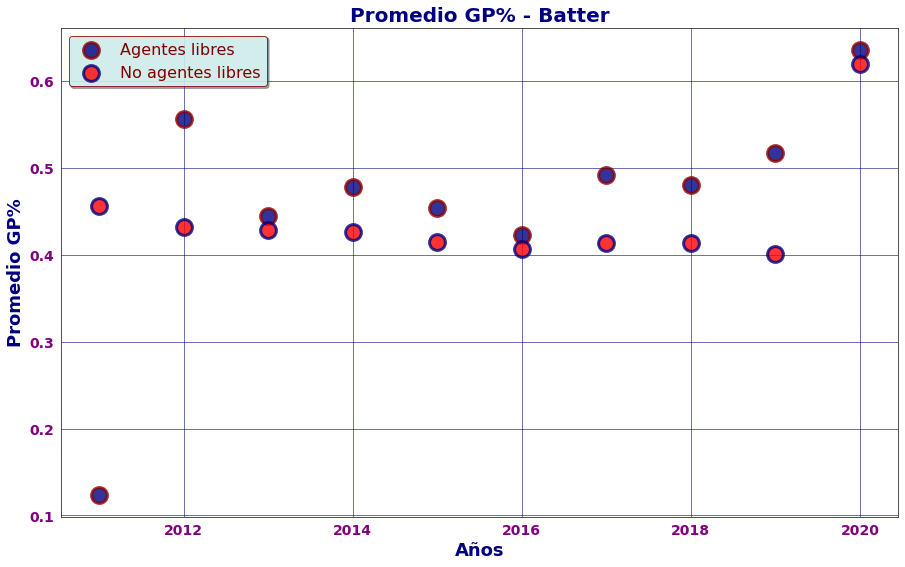

In [66]:
sns.set_style('white')
sns.regplot(x = anios, y = promedio_porcentaje_juegos_hitters_free_agents,
            fit_reg = False, label = "Agentes libres",
            scatter_kws={"color": 'navy', 'edgecolor':'darkred', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
sns.regplot(x = anios, y = promedio_porcentaje_juegos_hitters_no_free_agents, 
            fit_reg = False, label = "No agentes libres",
            scatter_kws={"color": 'red', 'edgecolor':'navy', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
plt.title("Promedio GP% - Batter", 
          fontsize = 20, fontweight = 'bold',
          color = 'navy')
plt.xlabel("Años", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.ylabel("Promedio GP%", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.xticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.yticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.legend(loc = 'best', fontsize=16, 
           labelcolor = 'maroon', facecolor = 'lightcyan',
           edgecolor = 'maroon', framealpha = 0.8,
           fancybox = True, shadow = True)
plt.grid(color = 'navy', linestyle='-', alpha = 0.7)
plt.show()

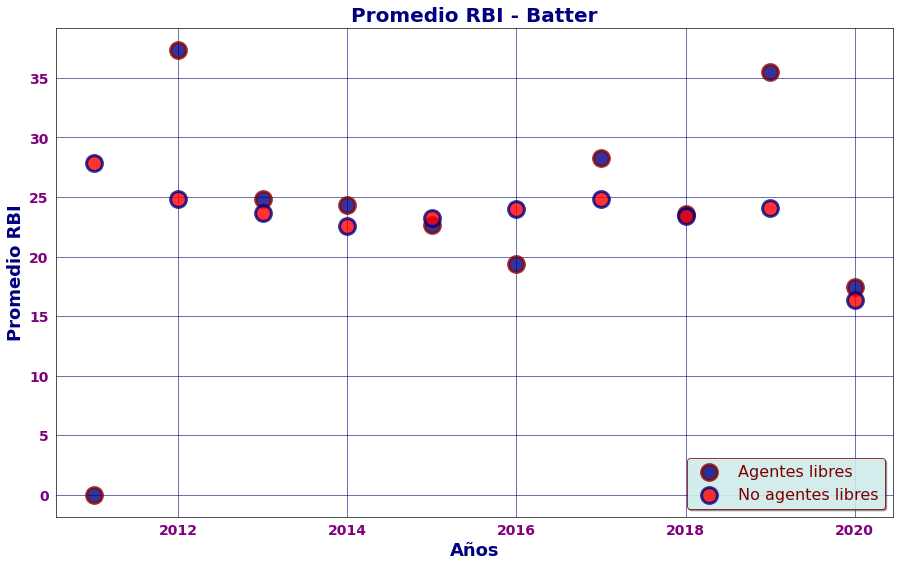

In [67]:
sns.set_style('white')
sns.regplot(x = anios, y = promedio_RBI_hitters_free_agents,
            fit_reg = False, label = "Agentes libres",
            scatter_kws={"color": 'navy', 'edgecolor':'darkred', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
sns.regplot(x = anios, y = promedio_RBI_hitters_no_free_agents, 
            fit_reg = False, label = "No agentes libres",
            scatter_kws={"color": 'red', 'edgecolor':'navy', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
plt.title("Promedio RBI - Batter", 
          fontsize = 20, fontweight = 'bold',
          color = 'navy')
plt.xlabel("Años", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.ylabel("Promedio RBI", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.xticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.yticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.legend(loc = 'best', fontsize=16, 
           labelcolor = 'maroon', facecolor = 'lightcyan',
           edgecolor = 'maroon', framealpha = 0.8,
           fancybox = True, shadow = True)
plt.grid(color = 'navy', linestyle='-', alpha = 0.7)
plt.show()

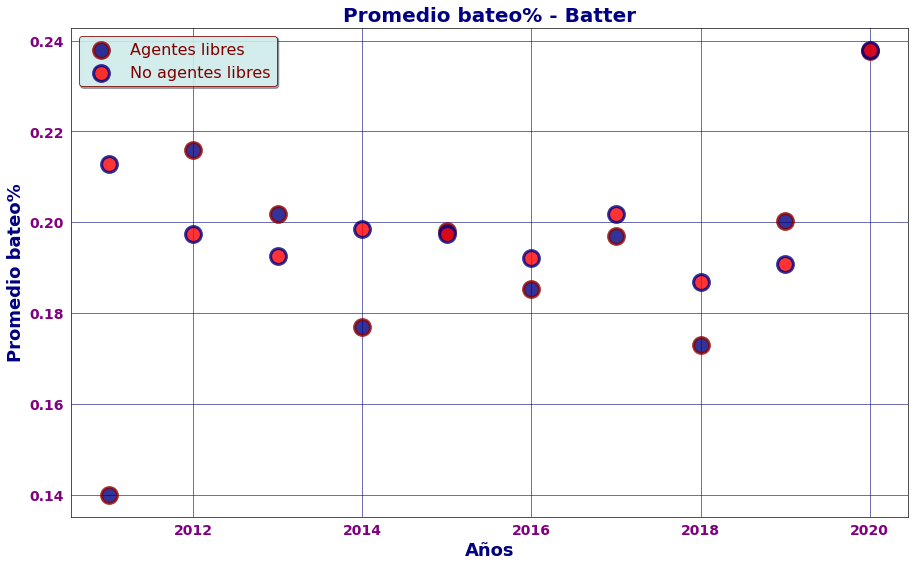

In [68]:
sns.set_style('white')
sns.regplot(x = anios, y = promedio_porcentaje_bateo_hitters_free_agents,
            fit_reg = False, label = "Agentes libres",
            scatter_kws={"color": 'navy', 'edgecolor':'darkred', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
sns.regplot(x = anios, y = promedio_porcentaje_bateo_hitters_no_free_agents, 
            fit_reg = False, label = "No agentes libres",
            scatter_kws={"color": 'red', 'edgecolor':'navy', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
plt.title("Promedio bateo% - Batter", 
          fontsize = 20, fontweight = 'bold',
          color = 'navy')
plt.xlabel("Años", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.ylabel("Promedio bateo%", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.xticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.yticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.legend(loc = 'best', fontsize=16, 
           labelcolor = 'maroon', facecolor = 'lightcyan',
           edgecolor = 'maroon', framealpha = 0.8,
           fancybox = True, shadow = True)
plt.grid(color = 'navy', linestyle='-', alpha = 0.7)
plt.show()

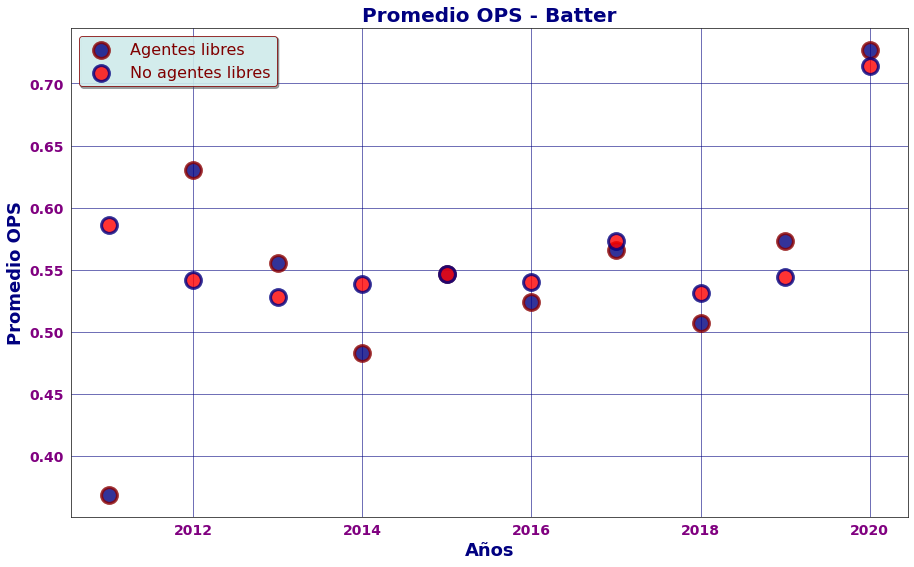

In [69]:
sns.set_style('white')
sns.regplot(x = anios, y = promedio_OPS_hitters_free_agents,
            fit_reg = False, label = "Agentes libres",
            scatter_kws={"color": 'navy', 'edgecolor':'darkred', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
sns.regplot(x = anios, y = promedio_OPS_hitters_no_free_agents, 
            fit_reg = False, label = "No agentes libres",
            scatter_kws={"color": 'red', 'edgecolor':'navy', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
plt.title("Promedio OPS - Batter", 
          fontsize = 20, fontweight = 'bold',
          color = 'navy')
plt.xlabel("Años", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.ylabel("Promedio OPS", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.xticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.yticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.legend(loc = 'best', fontsize=16, 
           labelcolor = 'maroon', facecolor = 'lightcyan',
           edgecolor = 'maroon', framealpha = 0.8,
           fancybox = True, shadow = True)
plt.grid(color = 'navy', linestyle='-', alpha = 0.7)
plt.show()

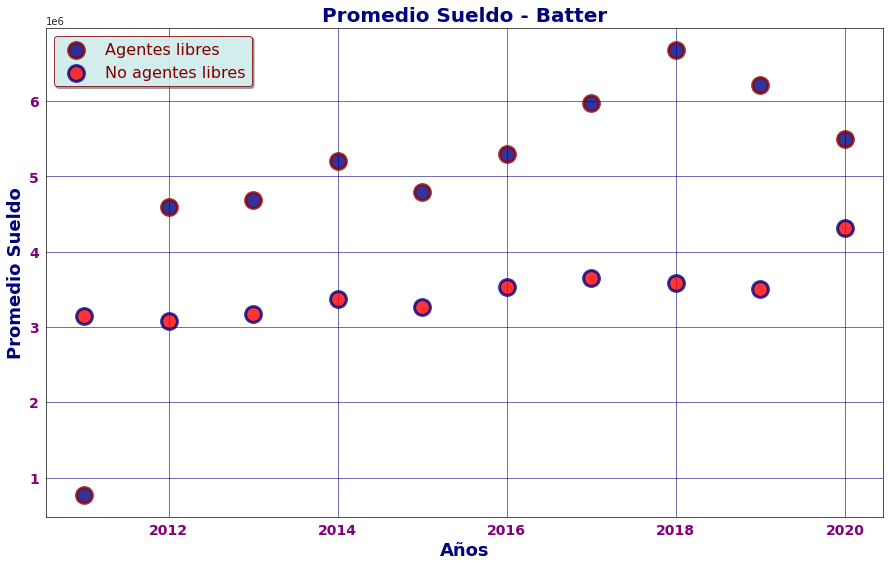

In [70]:
sns.set_style('white')
sns.regplot(x = anios, y = promedio_sueldo_hitters_free_agents,
            fit_reg = False, label = "Agentes libres",
            scatter_kws={"color": 'navy', 'edgecolor':'darkred', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
sns.regplot(x = anios, y = promedio_sueldo_hitters_no_free_agents, 
            fit_reg = False, label = "No agentes libres",
            scatter_kws={"color": 'red', 'edgecolor':'navy', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
plt.title("Promedio Sueldo - Batter", 
          fontsize = 20, fontweight = 'bold',
          color = 'navy')
plt.xlabel("Años", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.ylabel("Promedio Sueldo", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.xticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.yticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.legend(loc = 'best', fontsize=16, 
           labelcolor = 'maroon', facecolor = 'lightcyan',
           edgecolor = 'maroon', framealpha = 0.8,
           fancybox = True, shadow = True)
plt.grid(color = 'navy', linestyle='-', alpha = 0.7)
plt.show()

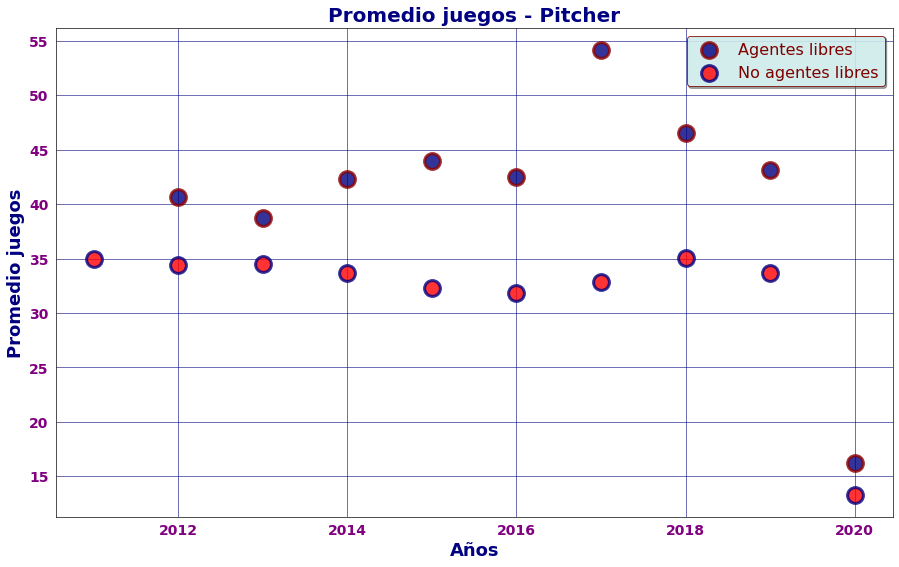

In [71]:
sns.set_style('white')
sns.regplot(x = anios, y = promedio_juegos_pitchers_free_agents,
            fit_reg = False, label = "Agentes libres",
            scatter_kws={"color": 'navy', 'edgecolor':'darkred', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
sns.regplot(x = anios, y = promedio_juegos_pitchers_no_free_agents, 
            fit_reg = False, label = "No agentes libres",
            scatter_kws={"color": 'red', 'edgecolor':'navy', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
plt.title("Promedio juegos - Pitcher", 
          fontsize = 20, fontweight = 'bold',
          color = 'navy')
plt.xlabel("Años", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.ylabel("Promedio juegos", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.xticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.yticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.legend(loc = 'best', fontsize=16, 
           labelcolor = 'maroon', facecolor = 'lightcyan',
           edgecolor = 'maroon', framealpha = 0.8,
           fancybox = True, shadow = True)
plt.grid(color = 'navy', linestyle='-', alpha = 0.7)
plt.show()

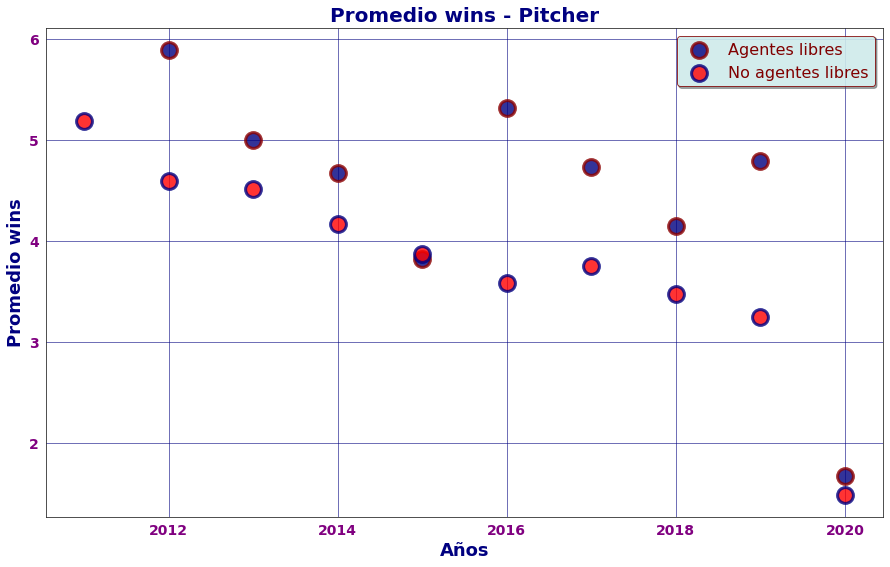

In [72]:
sns.set_style('white')
sns.regplot(x = anios, y = promedio_wins_pitchers_free_agents,
            fit_reg = False, label = "Agentes libres",
            scatter_kws={"color": 'navy', 'edgecolor':'darkred', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
sns.regplot(x = anios, y = promedio_wins_pitchers_no_free_agents, 
            fit_reg = False, label = "No agentes libres",
            scatter_kws={"color": 'red', 'edgecolor':'navy', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
plt.title("Promedio wins - Pitcher", 
          fontsize = 20, fontweight = 'bold',
          color = 'navy')
plt.xlabel("Años", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.ylabel("Promedio wins", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.xticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.yticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.legend(loc = 'best', fontsize=16, 
           labelcolor = 'maroon', facecolor = 'lightcyan',
           edgecolor = 'maroon', framealpha = 0.8,
           fancybox = True, shadow = True)
plt.grid(color = 'navy', linestyle='-', alpha = 0.7)
plt.show()

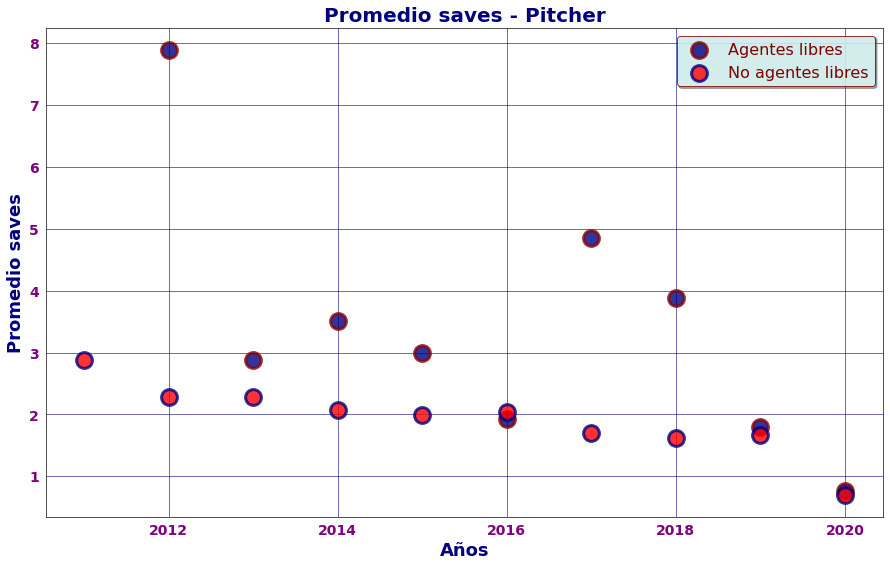

In [73]:
sns.set_style('white')
sns.regplot(x = anios, y = promedio_saves_pitchers_free_agents,
            fit_reg = False, label = "Agentes libres",
            scatter_kws={"color": 'navy', 'edgecolor':'darkred', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
sns.regplot(x = anios, y = promedio_saves_pitchers_no_free_agents, 
            fit_reg = False, label = "No agentes libres",
            scatter_kws={"color": 'red', 'edgecolor':'navy', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
plt.title("Promedio saves - Pitcher", 
          fontsize = 20, fontweight = 'bold',
          color = 'navy')
plt.xlabel("Años", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.ylabel("Promedio saves", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.xticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.yticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.legend(loc = 'best', fontsize=16, 
           labelcolor = 'maroon', facecolor = 'lightcyan',
           edgecolor = 'maroon', framealpha = 0.8,
           fancybox = True, shadow = True)
plt.grid(color = 'navy', linestyle='-', alpha = 0.7)
plt.show()

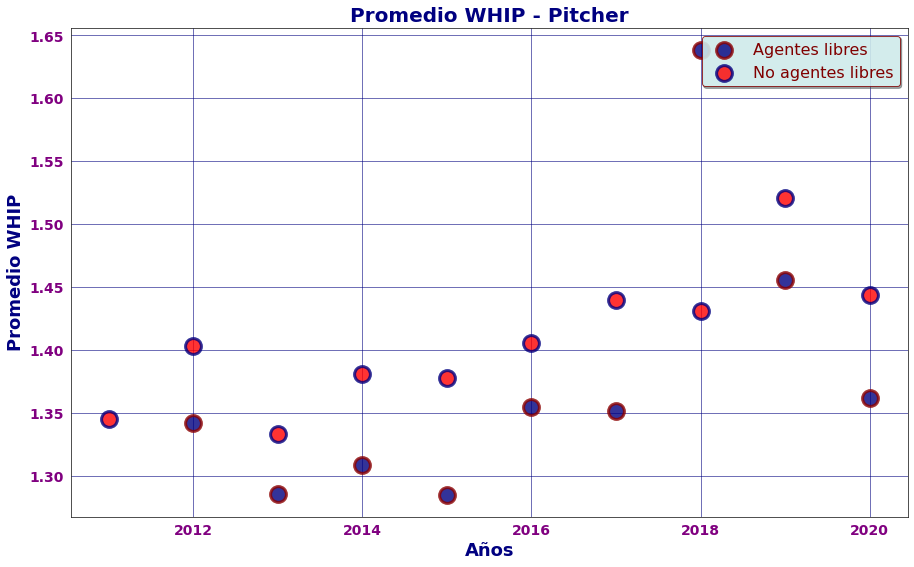

In [74]:
sns.set_style('white')
sns.regplot(x = anios, y = promedio_WHIP_pitchers_free_agents,
            fit_reg = False, label = "Agentes libres",
            scatter_kws={"color": 'navy', 'edgecolor':'darkred', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
sns.regplot(x = anios, y = promedio_WHIP_pitchers_no_free_agents, 
            fit_reg = False, label = "No agentes libres",
            scatter_kws={"color": 'red', 'edgecolor':'navy', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
plt.title("Promedio WHIP - Pitcher", 
          fontsize = 20, fontweight = 'bold',
          color = 'navy')
plt.xlabel("Años", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.ylabel("Promedio WHIP", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.xticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.yticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.legend(loc = 'best', fontsize=16, 
           labelcolor = 'maroon', facecolor = 'lightcyan',
           edgecolor = 'maroon', framealpha = 0.8,
           fancybox = True, shadow = True)
plt.grid(color = 'navy', linestyle='-', alpha = 0.7)
plt.show()

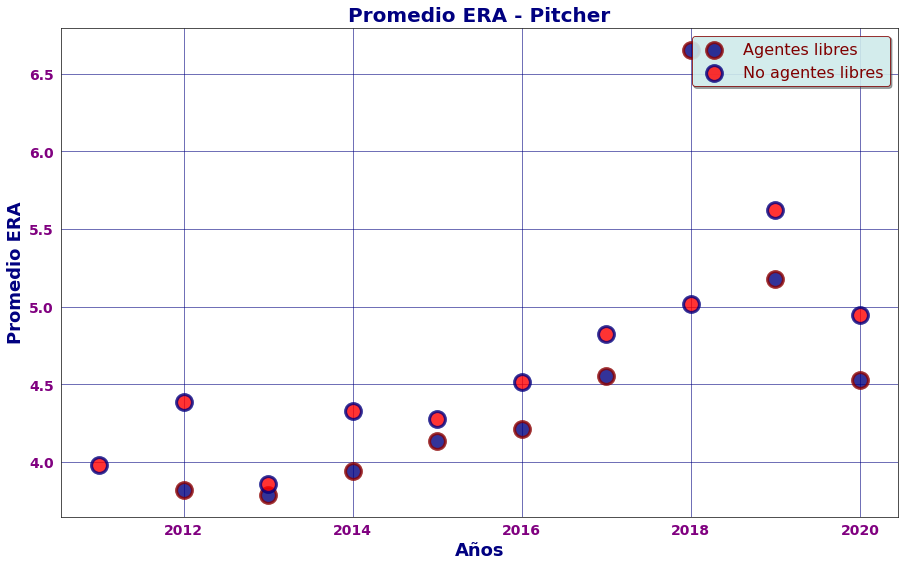

In [75]:
sns.set_style('white')
sns.regplot(x = anios, y = promedio_ERA_pitchers_free_agents,
            fit_reg = False, label = "Agentes libres",
            scatter_kws={"color": 'navy', 'edgecolor':'darkred', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
sns.regplot(x = anios, y = promedio_ERA_pitchers_no_free_agents, 
            fit_reg = False, label = "No agentes libres",
            scatter_kws={"color": 'red', 'edgecolor':'navy', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
plt.title("Promedio ERA - Pitcher", 
          fontsize = 20, fontweight = 'bold',
          color = 'navy')
plt.xlabel("Años", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.ylabel("Promedio ERA", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.xticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.yticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.legend(loc = 'best', fontsize=16, 
           labelcolor = 'maroon', facecolor = 'lightcyan',
           edgecolor = 'maroon', framealpha = 0.8,
           fancybox = True, shadow = True)
plt.grid(color = 'navy', linestyle='-', alpha = 0.7)
plt.show()

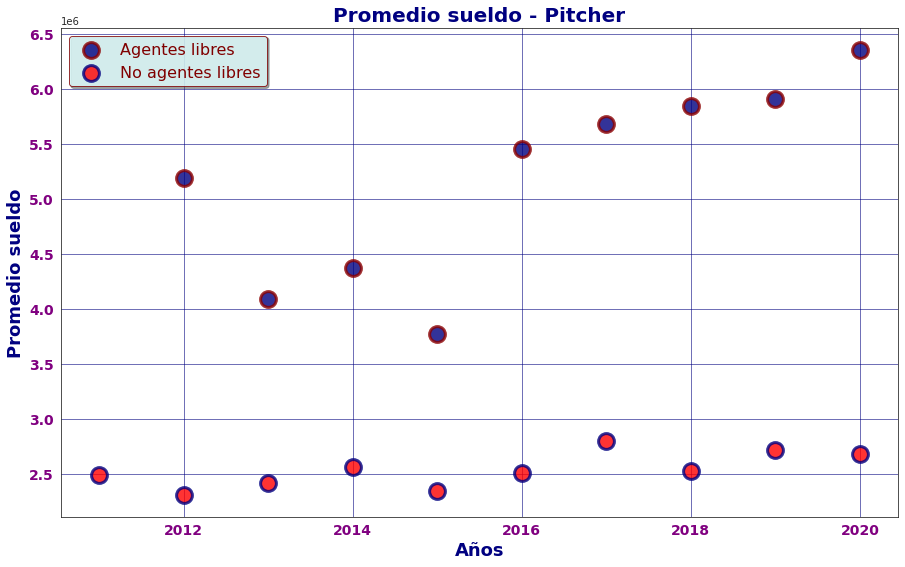

In [76]:
sns.set_style('white')
sns.regplot(x = anios, y = promedio_sueldo_pitchers_free_agents,
            fit_reg = False, label = "Agentes libres",
            scatter_kws={"color": 'navy', 'edgecolor':'darkred', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
sns.regplot(x = anios, y = promedio_sueldo_pitchers_no_free_agents, 
            fit_reg = False, label = "No agentes libres",
            scatter_kws={"color": 'red', 'edgecolor':'navy', 
                         "s":250, "alpha":0.8, "linewidth":3},
            line_kws={"color": "#8e00ce"})
plt.title("Promedio sueldo - Pitcher", 
          fontsize = 20, fontweight = 'bold',
          color = 'navy')
plt.xlabel("Años", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.ylabel("Promedio sueldo", fontsize = 18, fontweight = 'bold',
          color = 'navy')
plt.xticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.yticks(fontsize = 14, fontweight = 'bold',
           color = 'purple')
plt.legend(loc = 'best', fontsize=16, 
           labelcolor = 'maroon', facecolor = 'lightcyan',
           edgecolor = 'maroon', framealpha = 0.8,
           fancybox = True, shadow = True)
plt.grid(color = 'navy', linestyle='-', alpha = 0.7)
plt.show()

## Cosas a corregir:

### Limpieza de datos

Debido al método usado, se generan valores tipo *NaN* en las columnas de datos que no tienen en común. Una de las propuestas, es rellenar las columnas númericas con el valor 0 puesto que si dicho jugador no está operando en dicha tem,porada, pues no está generando ninguna estadística. Por otro lado, para los valores de cadena de texto se propone rellenarlos con la palabra *Ninguno*.

## Modelos

A continuación, utilizaremos el modelo de clasificación *Naive Bayes* para determinar si un jugador es o no un agente libre

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix

In [131]:
# Creemos la lista que contenga los datos relevantes obtenidos por el modelo
Anios = 10
X = [None]*Anios
y_h_pred = [None]*Anios
y_p_pred = [None]*Anios
# Modelos
classifier_nv = [None]*Anios
# Matriz de confusión
confussion_matrix_h_nv = [None]*Anios
confussion_matrix_p_nv = [None]*Anios
# Años
Anios_list = [i for i in range(2011,2021)]
# Auxiliar
accuracy_scores_train_h = np.ones((Anios))
accuracy_scores_test_h = np.ones((Anios))
accuracy_scores_train_p = np.ones((Anios))
accuracy_scores_test_p = np.ones((Anios))

In [149]:
for i in range(Anios):
    X[i] = df_pitchers[i].iloc[:,[1,2,3,4,5,7]].values
    y = df_pitchers[i].iloc[:,8:9].values
    
    labelencoder_y = LabelEncoder()
    y = labelencoder_y.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X[i], y, 
                                                        test_size = 0.25, 
                                                        random_state = 0)
    
    classifier_nv[i] = GaussianNB()
    classifier_nv[i].fit(X_train, y_train)
        
    y_p_pred[i] = classifier_nv[i].predict(X_test)
    
    accuracy_scores_train_p[i] = classifier_nv[i].score(X_train, y_train)
    accuracy_scores_test_p[i] = classifier_nv[i].score(X_test, y_test)
    print(accuracy_scores_train_p[i])
    print(accuracy_scores_test_p[i])
    print("")

    confussion_matrix_p_nv[i] = confusion_matrix(y_test, y_p_pred[i])

1.0
1.0

0.9439252336448598
0.9719626168224299

0.8763736263736264
0.8934426229508197

0.8557213930348259
0.9253731343283582

0.8639455782312925
0.8513513513513513

0.8590604026845637
0.8590604026845637

0.9357798165137615
0.910958904109589

0.8902691511387164
0.8881987577639752

0.9326732673267327
0.9171597633136095

0.875
0.8970588235294118



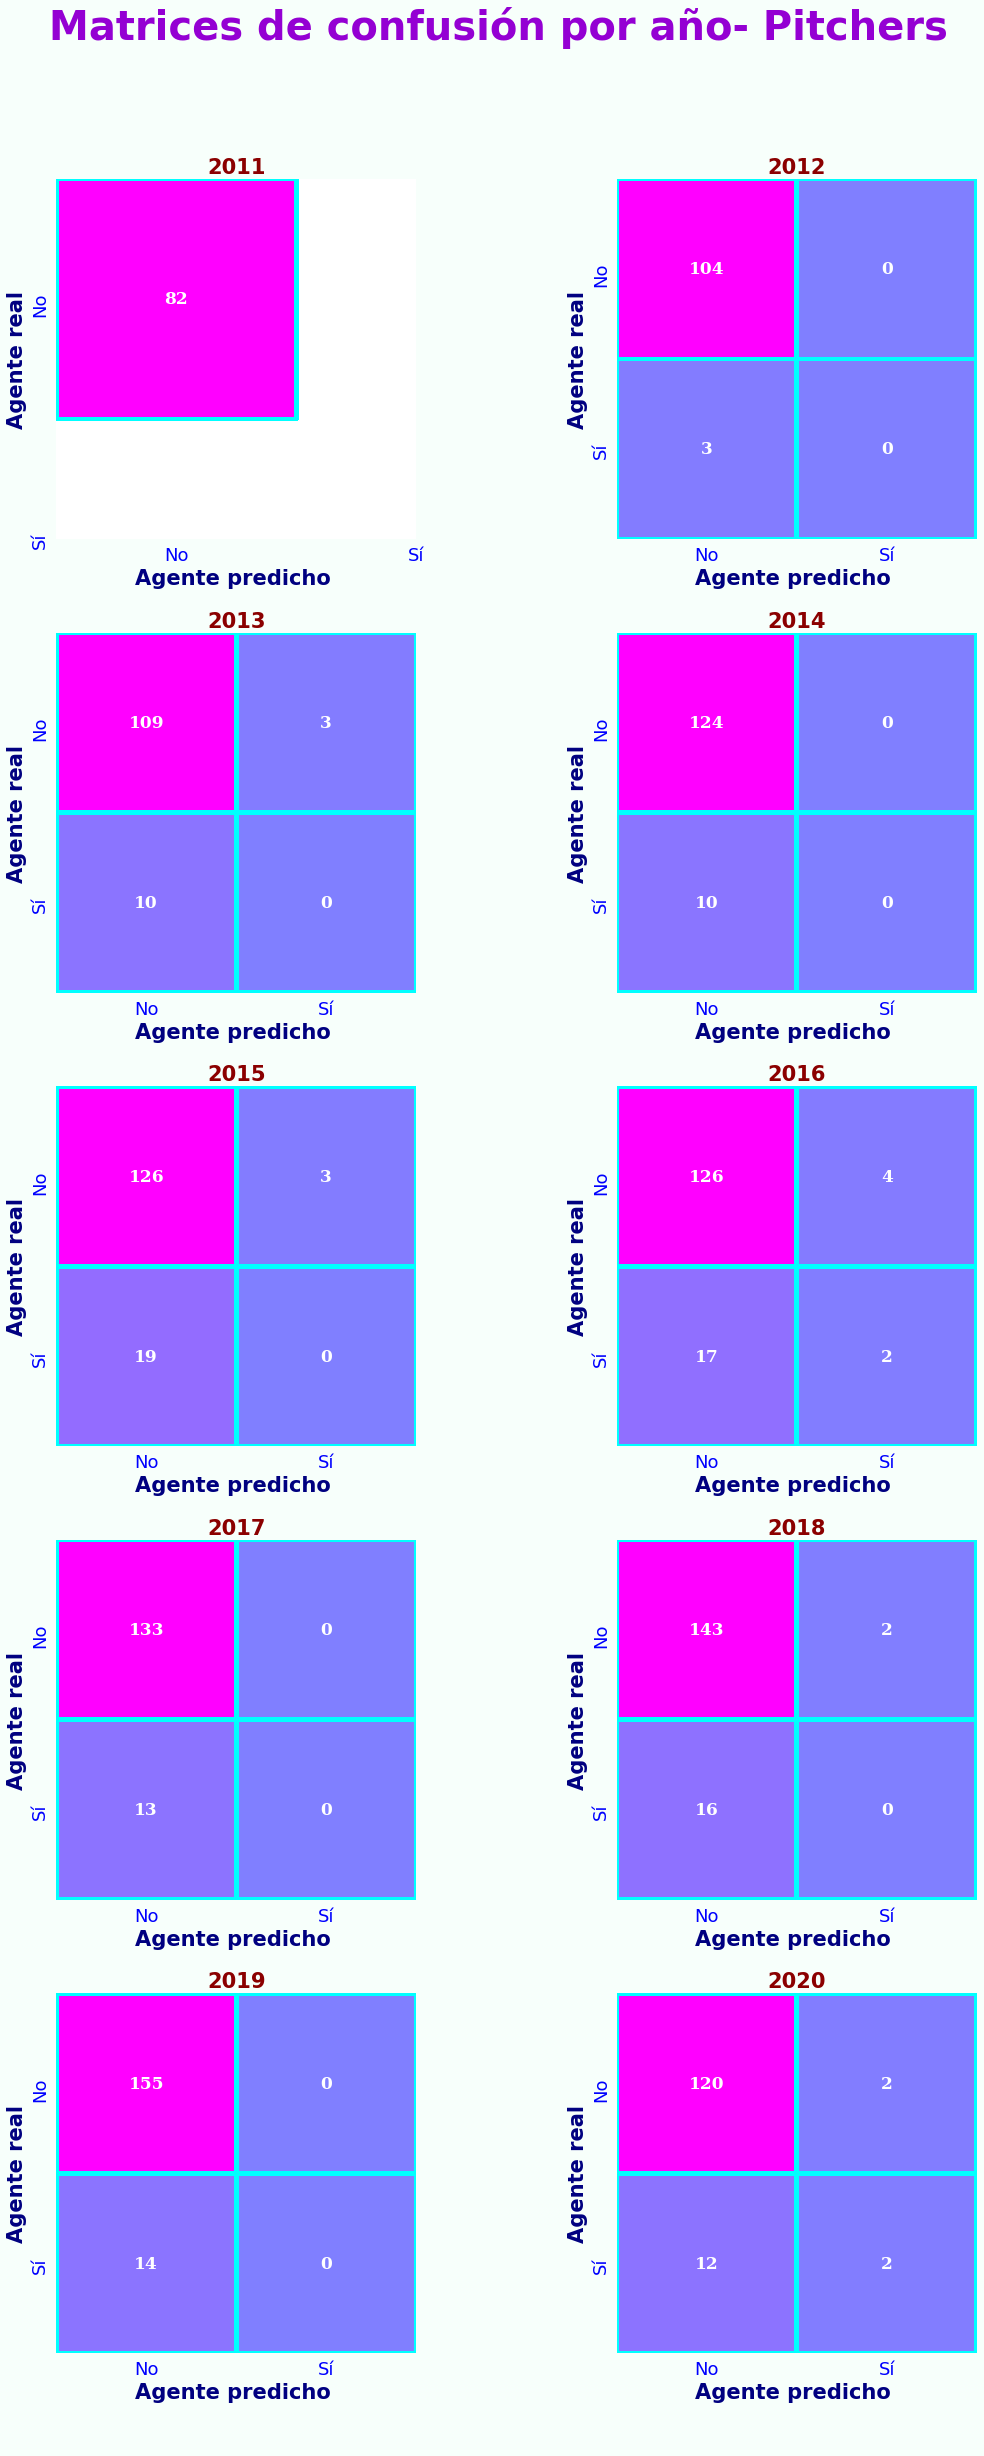

In [151]:
sns.set_style('white')
fig,axes = plt.subplots(5,2, figsize=(20,40))
fig.suptitle("Matrices de confusión por año- Pitchers", 
           fontsize = 40,
           color = 'darkviolet', 
           fontweight = 'bold', 
           y = 0.94)
fig.patch.set_facecolor('mintcream')
fig.patch.set_alpha(0.8)

# Crearemos un arreglo de heatmaps para movernos en sus índices
heatmaps = [None]*Anios

# Personalizaremos con un doble bucle cada gráfico del subplot
# Como es una matriz de dos dimensiones, por lo que se tendrá
# que hacer el doble bucle, nos apoyaremos de los códigos
# anteriores que ya se han hecho, pero solo los indexaremos
# y utilizando listas para personalizar títulos y etiquetas.

# Tomaremos un índice auxiliar para las etiquetas y gráficos
k = 0
for i in range(5):
    for j in range(2):
        # Crearemos una lista que contenga el total de cada grupo en un formato sin decimales
        cuenta_grupo = ["{0:0.0f}".format(value) for value in 
                        confussion_matrix_p_nv[k].flatten()]

        # Análogo al algoritmo anterior, pero ahora sacamos los porcentajes absolutos
        porcentage_grupo = ["{0:.2%}".format(value) for value in 
                             (confussion_matrix_p_nv[k].flatten())/np.sum(confussion_matrix_p_nv[k])]

        # Las etiquetas las sacaremos relativas a las lista anteriores
        labels = [f"{v1}\n{v2}\n" for v1, v2 in
                  zip(cuenta_grupo,porcentage_grupo)]
        
        if k != 0:
            labels = np.asarray(labels).reshape(2,2)
        else:
            labels = np.asarray(labels).reshape(1)
        
        heatmaps[k] = sns.heatmap(confussion_matrix_p_nv[k], 
                                  annot = True, cmap = 'cool',
                                  xticklabels = labels_cl_new, yticklabels = labels_cl_new, 
                                  annot_kws = {"size": 17, 
                                               'fontweight':'bold', 
                                               'fontfamily':'serif'},
                                  fmt = "", cbar = False, center = 0, square = True,
                                  linewidth = 4, linecolor = 'cyan', ax = axes[i,j])
                    
        axes[i,j].set_title(str(Anios_list[k]),
                            fontsize = 21, fontweight = 'bold',
                            color = 'darkred')
        axes[i,j].set_xlabel('Agente predicho \n \n',
                             fontsize = 21, fontweight = 'bold',
                             color = 'navy')
        axes[i,j].set_ylabel('Agente real',
                             fontsize = 21, fontweight = 'bold',
                             color = 'navy')
        axes[i,j].tick_params(labelsize = 18,
                              labelcolor = 'blue')
        
        k = k + 1

plt.subplots_adjust(wspace = 0.01, hspace = 0.26)
plt.show()

In [133]:
for i in range(Anios):
    X[i] = df_hitters[i].iloc[:,[1,2,3,4,6]].values
    y = df_hitters[i].iloc[:,7:8].values
    
    labelencoder_y = LabelEncoder()
    y = labelencoder_y.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X[i], y, 
                                                        test_size = 0.25, 
                                                        random_state = 0)
    
    classifier_nv[i] = GaussianNB()
    classifier_nv[i].fit(X_train, y_train)
        
    y_h_pred[i] = classifier_nv[i].predict(X_test)
    
    accuracy_scores_train_h[i] = classifier_nv[i].score(X_train, y_train)
    accuracy_scores_test_h[i] = classifier_nv[i].score(X_test, y_test)
    print(accuracy_scores_train_h[i])
    print(accuracy_scores_test_h[i])
    print("")

    confussion_matrix_h_nv[i] = confusion_matrix(y_test, y_h_pred[i])

1.0
1.0

0.9224652087475149
0.9404761904761905

0.9016393442622951
0.8695652173913043

0.8835616438356164
0.8769230769230769

0.8916256157635468
0.8872549019607843

0.8692185007974481
0.8571428571428571

0.9259868421052632
0.9064039408866995

0.9224555735056543
0.9516908212560387

0.9233176838810642
0.9248826291079812

0.9056047197640118
0.8508771929824561



In [145]:
labels_cl_new = ['No', 'Sí']

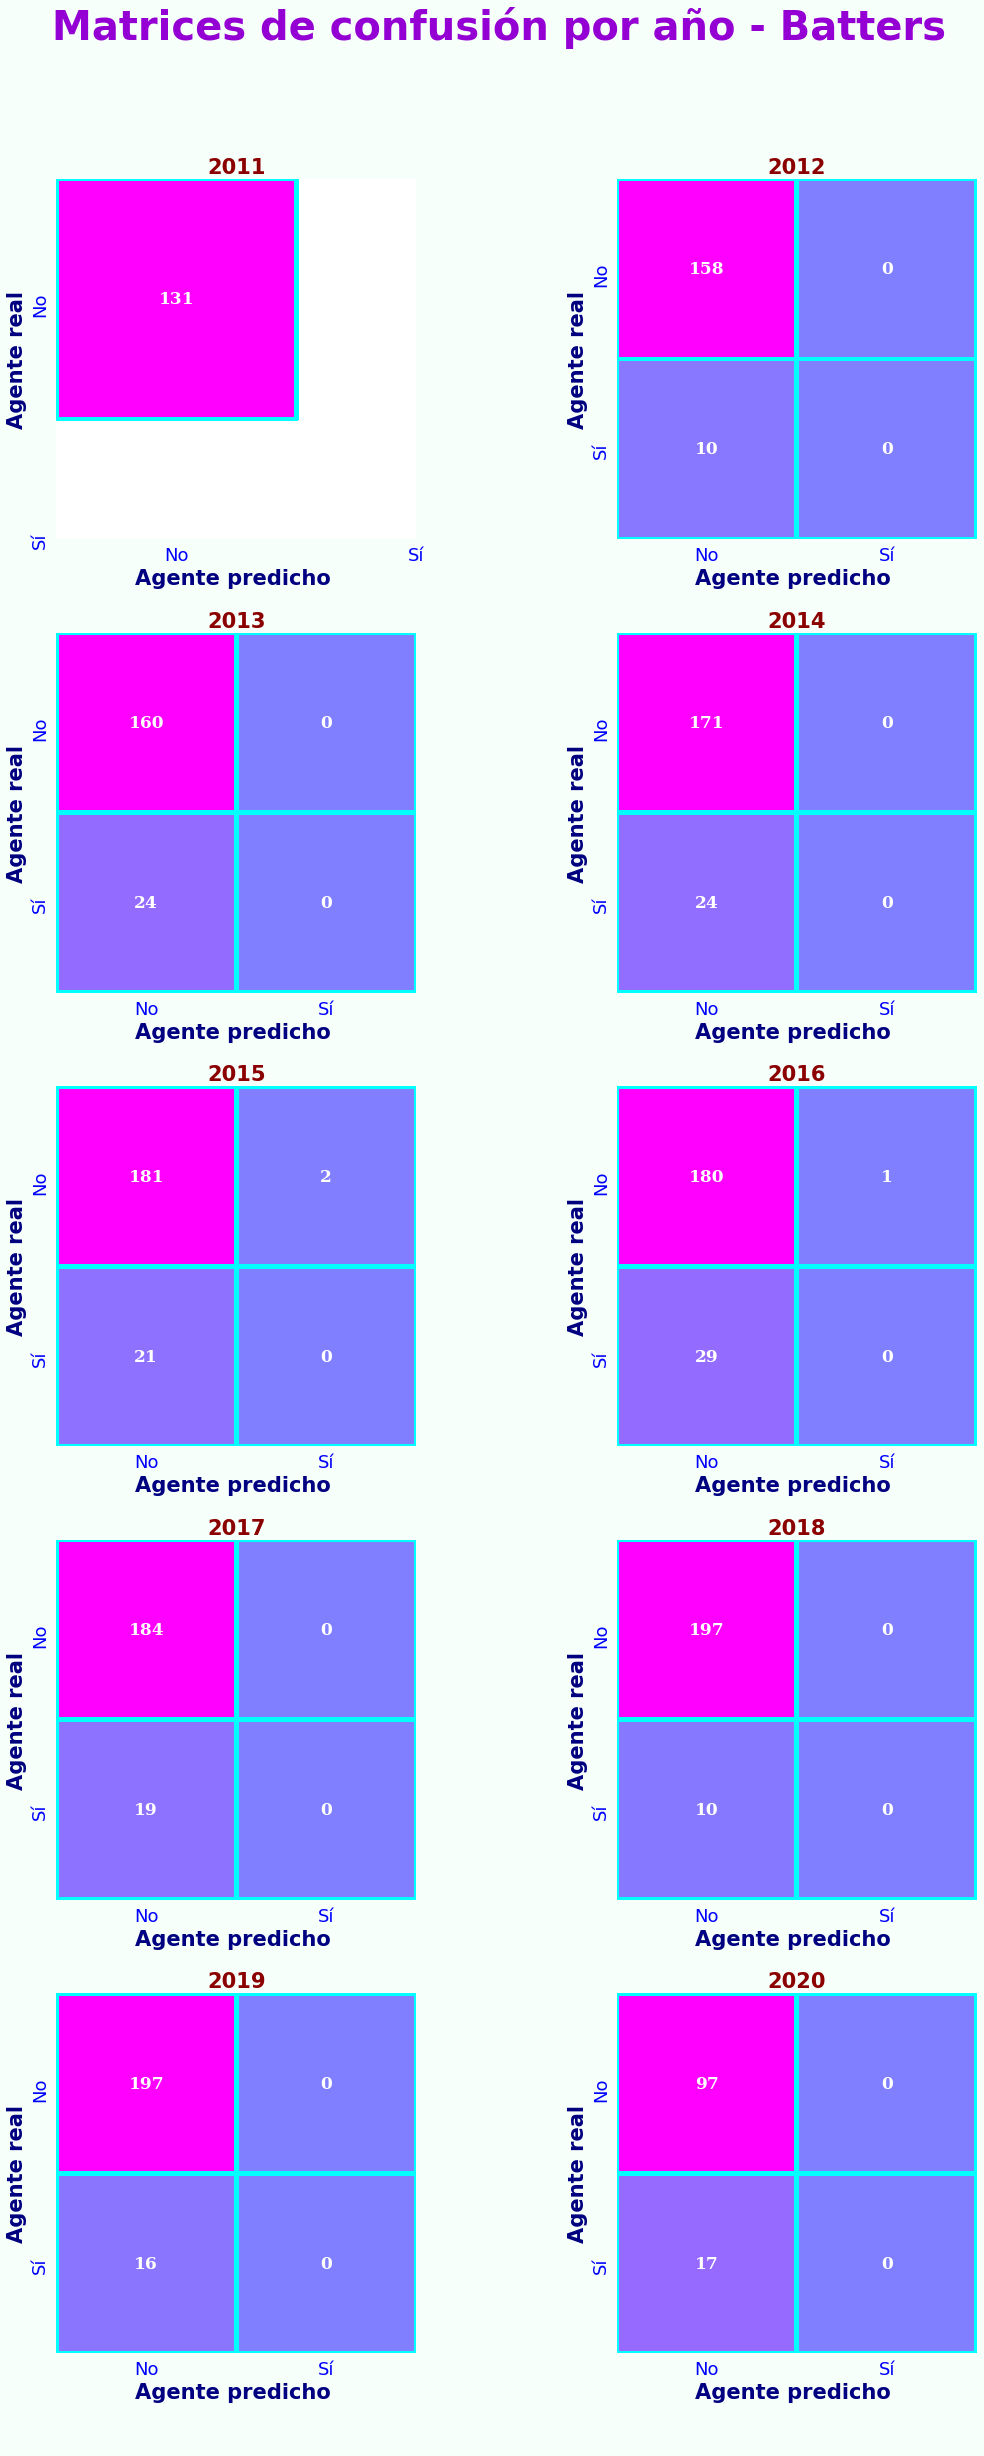

In [150]:
sns.set_style('white')
fig,axes = plt.subplots(5,2, figsize=(20,40))
fig.suptitle("Matrices de confusión por año - Batters", 
           fontsize = 40,
           color = 'darkviolet', 
           fontweight = 'bold', 
           y = 0.94)
fig.patch.set_facecolor('mintcream')
fig.patch.set_alpha(0.8)

# Crearemos un arreglo de heatmaps para movernos en sus índices
heatmaps = [None]*Anios

# Personalizaremos con un doble bucle cada gráfico del subplot
# Como es una matriz de dos dimensiones, por lo que se tendrá
# que hacer el doble bucle, nos apoyaremos de los códigos
# anteriores que ya se han hecho, pero solo los indexaremos
# y utilizando listas para personalizar títulos y etiquetas.

# Tomaremos un índice auxiliar para las etiquetas y gráficos
k = 0
for i in range(5):
    for j in range(2):
        # Crearemos una lista que contenga el total de cada grupo en un formato sin decimales
        cuenta_grupo = ["{0:0.0f}".format(value) for value in 
                        confussion_matrix_h_nv[k].flatten()]

        # Análogo al algoritmo anterior, pero ahora sacamos los porcentajes absolutos
        porcentage_grupo = ["{0:.2%}".format(value) for value in 
                             (confussion_matrix_h_nv[k].flatten())/np.sum(confussion_matrix_h_nv[k])]

        # Las etiquetas las sacaremos relativas a las lista anteriores
        labels = [f"{v1}\n{v2}\n" for v1, v2 in
                  zip(cuenta_grupo,porcentage_grupo)]
        
        if k != 0:
            labels = np.asarray(labels).reshape(2,2)
        else:
            labels = np.asarray(labels).reshape(1)
        
        heatmaps[k] = sns.heatmap(confussion_matrix_h_nv[k], 
                                  annot = True, cmap = 'cool',
                                  xticklabels = labels_cl_new, yticklabels = labels_cl_new, 
                                  annot_kws = {"size": 17, 
                                               'fontweight':'bold', 
                                               'fontfamily':'serif'},
                                  fmt = "", cbar = False, center = 0, square = True,
                                  linewidth = 4, linecolor = 'cyan', ax = axes[i,j])
                    
        axes[i,j].set_title(str(Anios_list[k]),
                            fontsize = 21, fontweight = 'bold',
                            color = 'darkred')
        axes[i,j].set_xlabel('Agente predicho \n \n',
                             fontsize = 21, fontweight = 'bold',
                             color = 'navy')
        axes[i,j].set_ylabel('Agente real',
                             fontsize = 21, fontweight = 'bold',
                             color = 'navy')
        axes[i,j].tick_params(labelsize = 18,
                              labelcolor = 'blue')
        
        k = k + 1

plt.subplots_adjust(wspace = 0.01, hspace = 0.26)
plt.show()

In [112]:
df_hitters[0].iloc[:,7:8]

,Agente libre
0,No
1,No
2,No
3,No
4,No
...,...
518,No
519,No
520,No
521,No


In [93]:
df_hitters[0].iloc[:,[1,2,3,4,6]]

,Porcetnaje_juegos_2011,RBI_2011,Porcentaje_bateo_2011,OPS_2011,Sueldo_2011
0,0.982,117,0.338,0.957,6375000
1,0.975,105,0.321,0.928,2500000
2,0.975,66,0.307,0.773,440000
3,0.957,87,0.306,0.809,1250000
4,0.994,105,0.344,1.033,20000000
...,...,...,...,...,...
518,0.025,0,0.000,0.000,414000
519,0.265,0,0.000,0.000,414000
520,0.019,0,0.000,0.000,414000
521,0.111,0,0.000,0.200,414000


In [100]:
df_pitchers[0]

,Jugador,Juegos_2011,Wins_2011,Saves_2011,WHIP_2011,ERA_2011,Equipo_2011,Sueldo_2011,Agente libre
0,Justin Verlander,34,24,0,0.92,2.40,DET,13416666,No
1,James Shields,33,16,0,1.04,2.82,TB,4250000,No
2,Dan Haren,35,16,0,1.02,3.17,LAA,12750000,No
3,C.C. Sabathia,33,19,0,1.23,3.00,NYY,25571428,No
4,Jered Weaver,33,18,0,1.01,2.41,LAA,7365000,No
...,...,...,...,...,...,...,...,...,...
321,Scott Kazmir,1,0,0,4.20,27.00,LAA,12000000,No
322,Rafael Dolis,1,0,0,0.75,0.00,CHC,414000,No
323,Michael Cuddyer,139,0,0,3.00,0.00,MIN,10525000,No
324,Skip Schumaker,117,0,0,2.00,18.00,STL,2700000,No


In [102]:
df_pitchers[0].iloc[:,[1,2,3,4,5,7]]

,Juegos_2011,Wins_2011,Saves_2011,WHIP_2011,ERA_2011,Sueldo_2011
0,34,24,0,0.92,2.40,13416666
1,33,16,0,1.04,2.82,4250000
2,35,16,0,1.02,3.17,12750000
3,33,19,0,1.23,3.00,25571428
4,33,18,0,1.01,2.41,7365000
...,...,...,...,...,...,...
321,1,0,0,4.20,27.00,12000000
322,1,0,0,0.75,0.00,414000
323,139,0,0,3.00,0.00,10525000
324,117,0,0,2.00,18.00,2700000
